# Loading libraries and dataframe with added locations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import sklearn as sk
plt.style.use('ggplot')

In [2]:
df=pd.read_csv('combined_data_with_loc.csv')
df.head()

,Community Name,Region,Map reference,Grid reference,Location,Population Density,Travel time to GPO (minutes),Distance to GPO (km),LGA,Primary Care Partnership,...,Travel time to nearest public hospital with emergency department,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %",geo_lat,geo_lon,cart_x,cart_y
0,Ascot Vale,Northern and Western Metropolitan,4,B3,6km NW of Melbourne,3758.623596,9.360142,6.958742,Moonee Valley (C),Inner North West Primary Care Partnership,...,6.630953,4.993841,679.257076,20.502456,1864.918123,56.290032,-37.775606,144.914871,-4.230377,4.251470
1,Braybrook,Northern and Western Metropolitan,4,A3,10km WNW of Melbourne,2025.468296,15.131666,11.595888,Maribyrnong (C),"HealthWest (b): Hobson's Bay, Maribyrnong, Wyn...",...,12.824977,10.161988,543.631989,20.647263,1683.966712,63.957428,-37.779315,144.858155,-9.212552,3.839001
2,Craigieburn,Northern and Western Metropolitan,2,A3,27km N of Melbourne,1034.970870,31.994666,43.100287,Hume (C),Hume-Whittlesea Primary Care Partnership,...,11.570855,15.213189,2044.424399,20.618005,5102.134434,51.454988,-37.570576,144.963028,0.000000,27.049690
3,Croydon,Eastern Metropolitan,2,B4,28km E of Melbourne,1730.064830,28.992647,34.071323,Maroondah (C),Outer East Primary Care Partnership,...,5.093285,3.601752,1754.954941,28.537825,3062.182462,49.795026,-37.813411,145.281013,27.933349,0.047723
4,Fawkner,Northern and Western Metropolitan,4,C1,12km N of Melbourne,2619.120089,17.405267,13.047142,Moreland (C),Inner North West Primary Care Partnership,...,11.510757,12.004044,680.401318,17.909865,1942.874353,51.141315,-37.705724,144.963028,0.000000,12.021947


In [3]:
print(df['Community Name'])

0            Ascot Vale
1             Braybrook
2           Craigieburn
3               Croydon
4               Fawkner
5             Footscray
6               Glenroy
7          Malvern East
8               Malvern
9     Melbourne Airport
10              Mentone
11            Moorabbin
12           Mordialloc
13          Murrumbeena
14           Noble Park
15      North Melbourne
16            Northcote
17            Parkville
18    Pascoe Vale South
19       Port Melbourne
20              Prahran
21           Somerville
22             Sorrento
23      South Melbourne
24          South Yarra
25           Springvale
26     St Andrews Beach
27        St Kilda East
28             St Kilda
29        St Kilda West
30               Toorak
31                Tyabb
32            Waterways
33              Windsor
Name: Community Name, dtype: object


Formatting locational data for downstream tasks

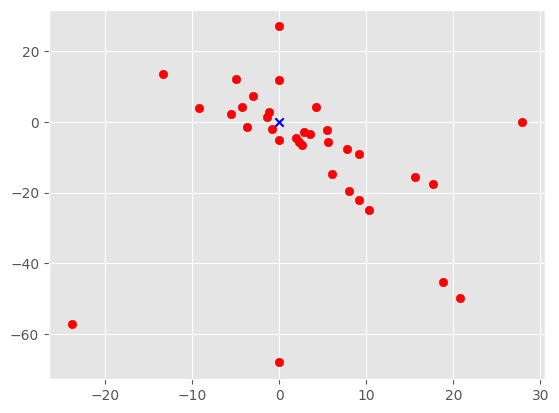

In [4]:
locs=np.asarray(list(zip(df['cart_x'],df['cart_y'])))

# plot locs on a scatter plot, with (0,0) at the center
plt.scatter(locs[:,0],locs[:,1],color='red')
plt.scatter(0,0,color='blue', marker='x')
plt.show()


# Beginning The Clustering Process

## Reasoning

Before addressing the hypothesis of "Nearby Suburbs are Similar", we first need to set up clusters of *_nearby_* suburbs. Afterwards, we'll address if the within-cluster locations are similar in nature using the metrics that we'll be defining afterwards.

The reasoning behind this approach is: 

We should not let the similarity metrics derived from the features influence the city-clustering, consciously or subconsciouly. We decide upon what qualifies as the close-by suburbs first, only then we judge upon the goodness of our hypothesis by our defined measures.

## Handling Locationally Outlier Suburbs

We'll decide the 'outliers' in two ways:
1. How far away they are from the origin (Melbourne GPO)
2. How much locally isolated the suburbs are

### 1. Distance from the Origin

We'll analyse the distribution in terms of each of the co-ordinates. We'll consider the suburbs with $(x,y)$ such that

 $x \not\in (Q^x_1-1.5\times IQR_x, Q^x_3+1.5\times IQR_x)$ $\text{OR}$ $y \not\in (Q^y_1-1.5\times IQR_y, Q^y_3+1.5\times IQR_y)$.

as outliers.

However, this is not exactly a good method on its own, since a few far away points from the origin even when clustered together will get rejected. We'll combine approaches 1 and 2. 


DescribeResult(nobs=34, minmax=(array([-23.8364841 , -68.12017913]), array([27.93334923, 27.04969046])), mean=array([ 3.19919332, -8.85161919]), variance=array([ 98.70338635, 416.25255756]), skewness=array([ 0.04737478, -1.29084182]), kurtosis=array([1.01840203, 1.52678611]))
[-1.34419175  2.4833545   7.96892529]
[-15.37890098  -4.08438017   2.65811421]


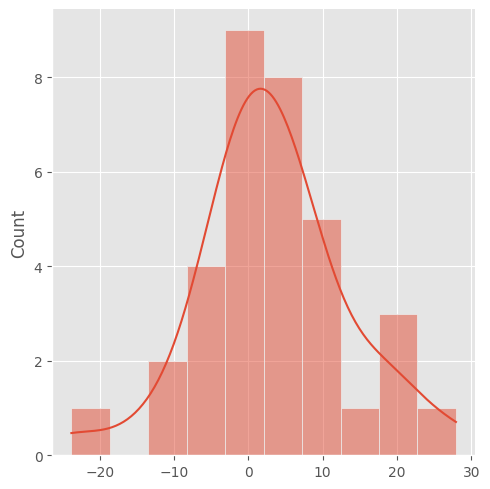

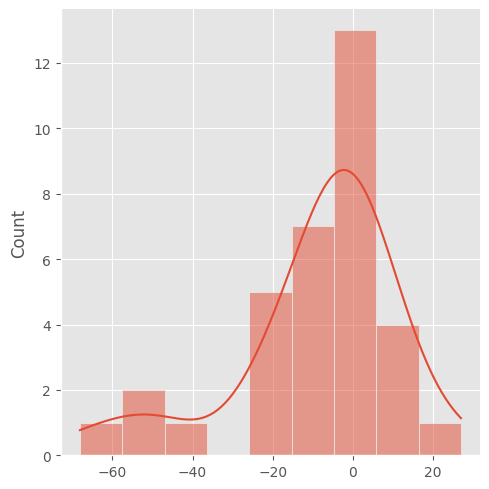

In [5]:
# describe the locational data
import scipy.stats as stats
print(stats.describe(locs))

# print the quartiles for the x and y coordinates
print(np.percentile(locs[:,0], [25, 50, 75]))
print(np.percentile(locs[:,1], [25, 50, 75]))

sns.displot(locs[:,0], kde=True)
plt.show()

sns.displot(locs[:,1], kde=True)
plt.show()




$x$ looks normally distributed, while $y$ does not. We'll test it.

In [6]:
# perform shapiro-wilk test for normality of x and y coordinates
print(stats.shapiro(locs[:,0]))
print(stats.shapiro(locs[:,1]))

# perform anderson-darling test for normality of x and y coordinates
print(stats.anderson(locs[:,0]))
print(stats.anderson(locs[:,1]))


ShapiroResult(statistic=np.float64(0.9670688954563095), pvalue=np.float64(0.3855347856075575))
ShapiroResult(statistic=np.float64(0.8707230058313595), pvalue=np.float64(0.00084308888086645))
AndersonResult(statistic=np.float64(0.5158051454446735), critical_values=array([0.526, 0.599, 0.718, 0.838, 0.996]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(3.199193322824144), scale=np.float64(9.934957793182829))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
AndersonResult(statistic=np.float64(1.7286553541403507), critical_values=array([0.526, 0.599, 0.718, 0.838, 0.996]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(-8.851619191333763), scale=np.float64(20.4022684415311))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


Both the tests confirm that $x$ is normally distributed and $y$ is not.

While this approach does not serve us too much at this point, it's good to have some idea what we'll be dealing with next.

We'll now visualize the sururbs on a scatterplot.

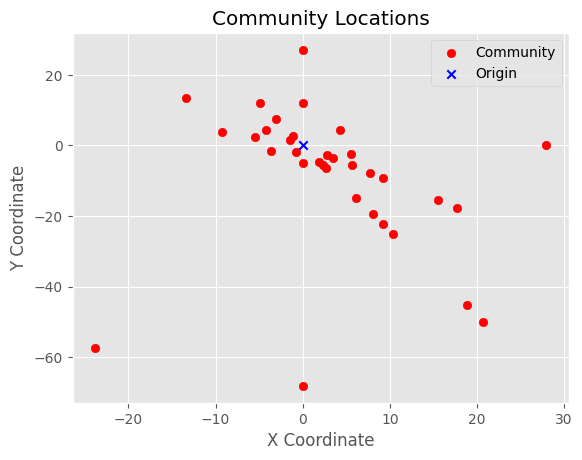

In [7]:
plt.scatter(locs[:,0],locs[:,1],color='red')
# scale the origin as well
origin = np.array([[0,0]])
# origin = scaler.transform(origin)
plt.scatter(origin[:,0],origin[:,1],color='blue', marker='x')
plt.legend(['Community','Origin'])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Community Locations')
plt.show()

We now figure out the quartiles and do a boxplot for the same.

DescribeResult(nobs=34, minmax=(array([-23.8364841 , -68.12017913]), array([27.93334923, 27.04969046])), mean=array([ 3.19919332, -8.85161919]), variance=array([ 98.70338635, 416.25255756]), skewness=array([ 0.04737478, -1.29084182]), kurtosis=array([1.01840203, 1.52678611]))
The x quartiles are: [-1.34419175  2.4833545   7.96892529]
The y quartiles are: [-15.37890098  -4.08438017   2.65811421]


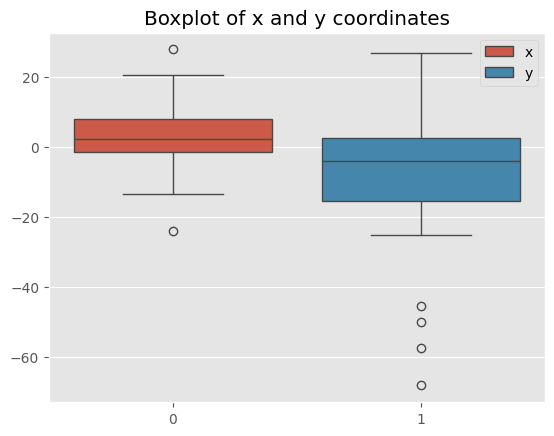

In [8]:
# Determine the distribution of the scaled data
print(stats.describe(locs))

# print the quartiles for the x and y coordinates
print('The x quartiles are:',np.percentile(locs[:,0], [25, 50, 75]))
print('The y quartiles are:',np.percentile(locs[:,1], [25, 50, 75]))

# do a boxplot of the scaled data
sns.boxplot(data=locs)
# show the legend
plt.legend(['x','y'])
plt.title('Boxplot of x and y coordinates')
plt.show()

As can be seen from the boxplot, the $y$ coordinate contains a bit more outliers as compared to $x$.

Number of outliers in x co-ordinate: 2
Number of outliers in y co-ordinate: 4
Total number of outliers (either in x or y): 5


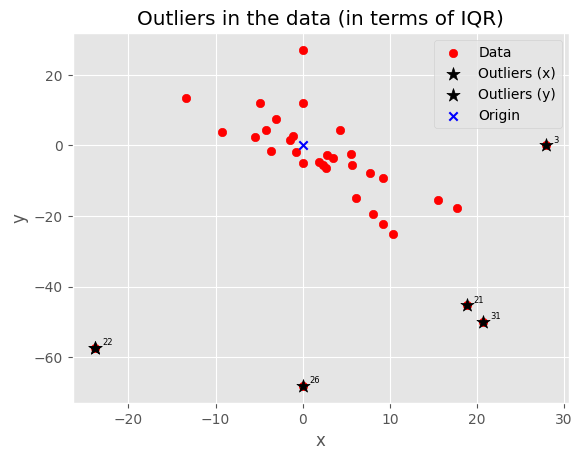

The outlier indices are: [ 3 21 22 26 31]
The corresponding community names are:
 3              Croydon
21          Somerville
22            Sorrento
26    St Andrews Beach
31               Tyabb
Name: Community Name, dtype: object


In [9]:
# count the number of 'outliers' in the scaled data in terms of IQR
# these are the far away points from the main 'mass' of the data
q1_x, q3_x = np.percentile(locs[:,0], [25, 75])
iqr_x = q3_x - q1_x
outliers_x = (locs[:,0] < q1_x - 1.5*iqr_x) | (locs[:,0] > q3_x + 1.5*iqr_x)
print('Number of outliers in x co-ordinate:',np.sum(outliers_x))

q1_y, q3_y = np.percentile(locs[:,1], [25, 75])
iqr_y = q3_y - q1_y
outliers_y = (locs[:,1] < q1_y - 1.5*iqr_y) | (locs[:,1] > q3_y + 1.5*iqr_y)
print('Number of outliers in y co-ordinate:',np.sum(outliers_y))

# count the total number of outliers
print('Total number of outliers (either in x or y):',np.sum(outliers_x | outliers_y))

# highlight the outliers in the scatter plot
plt.scatter(locs[:,0],locs[:,1],color='red')
plt.scatter(locs[outliers_x,0],locs[outliers_x,1],color='black', marker='*',s=100)
plt.scatter(locs[outliers_y,0],locs[outliers_y,1],color='black', marker='*',s=100)
plt.scatter(origin[:,0],origin[:,1],color='blue', marker='x')

# also annotate each outlier with the corresponding index
for i in np.where(outliers_x | outliers_y)[0]:
	plt.annotate(i, (locs[i,0]+.8,locs[i,1]+.8), fontsize=6)

# show the legend
plt.legend(['Data','Outliers (x)','Outliers (y)','Origin'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Outliers in the data (in terms of IQR)')
plt.show()

# print the outlier indices and the corresponding community names
coord_outliers = np.where(outliers_x | outliers_y)[0]
print('The outlier indices are:',coord_outliers)
print('The corresponding community names are:\n',df['Community Name'][coord_outliers])


### 2. Local Density Based Outlier Detection

In [10]:
# do a local outlier factor analysis on the distances
from sklearn.neighbors import LocalOutlierFactor

def get_lof_outliers(n_neighbors, top_k=5):
	lof = LocalOutlierFactor(n_neighbors=n_neighbors)
	lof.fit_predict(locs)
	# get the negative outlier factor
	lof_scores = lof.negative_outlier_factor_

	# pick the top 5 outliers
	top_lof_outliers = np.argsort(lof_scores)[:top_k]
	# print(f'The top 5 outliers detected by LOF with {n_neighbors} neighbors:',top_lof_outliers)
	# print('The corresponding community names are:\n',df['Community Name'][top_lof_outliers])

	return top_lof_outliers

# get the top 5 outliers
top_lof_outliers = get_lof_outliers(7)

print(f'The top 5 outliers detected by LOF with 7 neighbors:',top_lof_outliers)
print('The corresponding community names are:\n',df['Community Name'][top_lof_outliers])




The top 5 outliers detected by LOF with 7 neighbors: [ 3 22 26  2 31]
The corresponding community names are:
 3              Croydon
22            Sorrento
26    St Andrews Beach
2          Craigieburn
31               Tyabb
Name: Community Name, dtype: object


Since LOF is highly sensitive on the choice of $k$, we'll run the algorithm for multiple $k$'s and choose the most frequenty occuring suburbs.

The outliers selected based on max frequency are: [2, 3, 9, 16, 21, 22, 26, 31]
The corresponding community names are:
 2           Craigieburn
3               Croydon
9     Melbourne Airport
16            Northcote
21           Somerville
22             Sorrento
26     St Andrews Beach
31                Tyabb
Name: Community Name, dtype: object


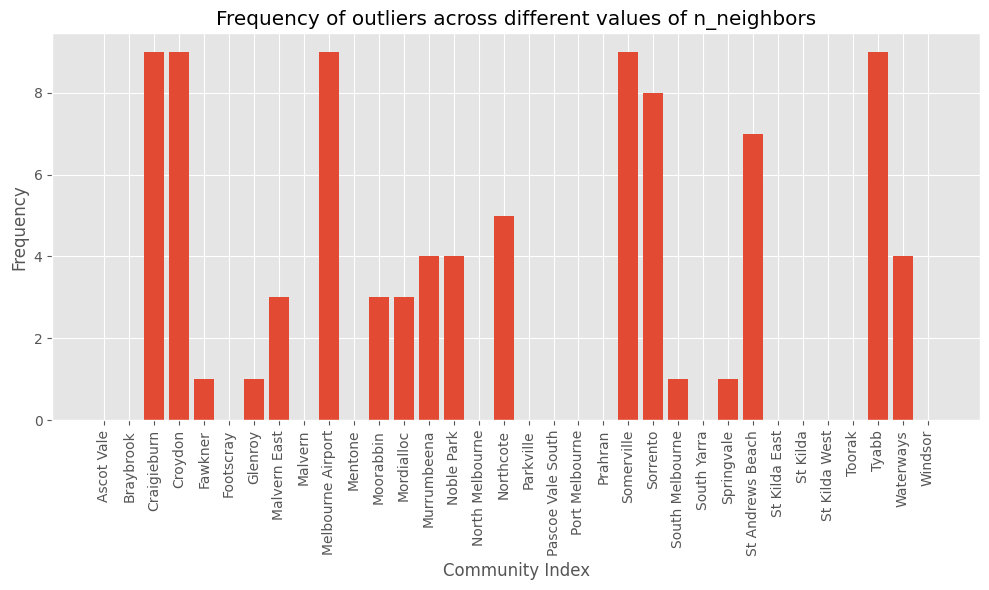

The outliers sorted based on frequency are: [ 0  1  5  8 10 15 18 30 24 27 29 28 20 19 17 33  4 25 23  6 11  7 12 13
 32 14 16 26 22  2  9  3 31 21]
The corresponding community names are:
 0            Ascot Vale
1             Braybrook
5             Footscray
8               Malvern
10              Mentone
15      North Melbourne
18    Pascoe Vale South
30               Toorak
24          South Yarra
27        St Kilda East
29        St Kilda West
28             St Kilda
20              Prahran
19       Port Melbourne
17            Parkville
33              Windsor
4               Fawkner
25           Springvale
23      South Melbourne
6               Glenroy
11            Moorabbin
7          Malvern East
12           Mordialloc
13          Murrumbeena
32            Waterways
14           Noble Park
16            Northcote
26     St Andrews Beach
22             Sorrento
2           Craigieburn
9     Melbourne Airport
3               Croydon
31                Tyabb
21           Somerv

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Example: Different values of n_neighbors to try
n_neighbors = [2, 3, 4, 5, 6, 7, 8, 9, 10]
top_lof_outliers = []

# Function to get outliers for each n_neighbors (assumes the existence of get_lof_outliers)
# get_lof_outliers(n, threshold) returns the indices of the top 'threshold' outliers.
for n in n_neighbors:
	top_lof_outliers.append(get_lof_outliers(n, 10))

# Count the frequency of each outlier across all values of n_neighbors
outlier_freq = np.zeros(len(locs))
for outlier_list in top_lof_outliers:
	for outlier in outlier_list:
		outlier_freq[outlier] += 1

# Select outliers that have the highest frequencies
# For example, we can choose outliers that appear in more than half of the n_neighbors runs
threshold = len(n_neighbors) // 2
max_freq_outliers = [i for i, freq in enumerate(outlier_freq) if freq > threshold]

# Print the selected outliers based on their frequency
print('The outliers selected based on max frequency are:', max_freq_outliers)
print('The corresponding community names are:\n', df['Community Name'][max_freq_outliers])

# Plot the frequency of each outlier
plt.figure(figsize=(10, 6))
plt.bar(range(len(outlier_freq)), outlier_freq)
plt.xlabel('Community Index')
plt.ylabel('Frequency')
plt.title('Frequency of outliers across different values of n_neighbors')
plt.xticks(range(len(locs)), df['Community Name'], rotation=90)
plt.tight_layout()
plt.show()

sorted_outlier_freq = np.argsort(outlier_freq)
print('The outliers sorted based on frequency are:', sorted_outlier_freq)
print('The corresponding community names are:\n', df['Community Name'][sorted_outlier_freq])

# select the top 8 outliers based on frequency
top_freq_outliers_LOF = sorted_outlier_freq[-8:]


Text(0.5, 0, 'x')

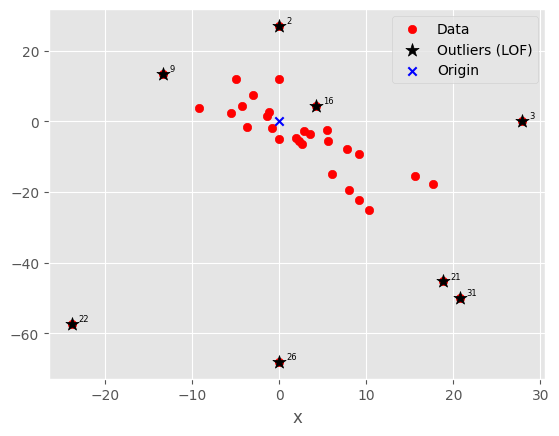

In [12]:
# plot the outliers detected by LOF
plt.scatter(locs[:,0],locs[:,1],color='red')
plt.scatter(locs[list(top_freq_outliers_LOF),0],locs[list(top_freq_outliers_LOF),1],color='black', marker='*',s=100)
plt.scatter(origin[:,0],origin[:,1],color='blue', marker='x')

# also annotate each outlier with the corresponding index
for i in top_freq_outliers_LOF:
	plt.annotate(i, (locs[i,0]+.8,locs[i,1]+.8), fontsize=6)

# show the legend
plt.legend(['Data','Outliers (LOF)','Origin'])
plt.xlabel('x')


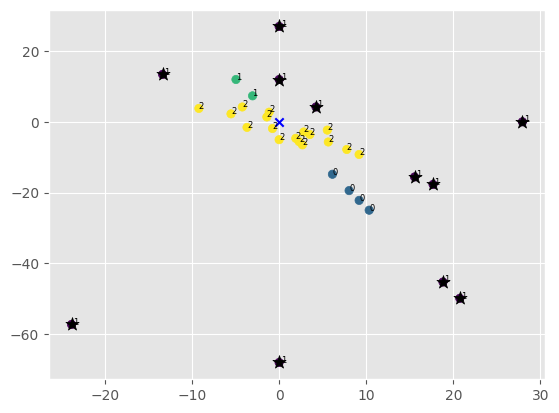

Number of clusters: 4
Number of noise points: 11


In [13]:
# Now do HDBSCAN clustering on the locational data

import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True, min_samples=2)
clusterer.fit(locs)

# plot the clusters
plt.scatter(locs[:,0],locs[:,1],c=clusterer.labels_)
plt.scatter(origin[:,0],origin[:,1],color='blue', marker='x')
# highlight the noise points
plt.scatter(locs[clusterer.labels_==-1,0],locs[clusterer.labels_==-1,1],color='black', marker='*',s=100)
# annotate each point with the corresponding cluster label
for i in range(len(locs)):
	plt.annotate(clusterer.labels_[i], (locs[i,0],locs[i,1]), size=6)

plt.show()
print('Number of clusters:',len(np.unique(clusterer.labels_)))
print('Number of noise points:',np.sum(clusterer.labels_==-1))

# get the indices of the noise points
noise_points_hdbscan = np.where(clusterer.labels_==-1)[0]

The noise points detected by HDBSCAN with min_cluster_size=2 and min_samples=1: [ 1  2  3  8  9 16 30]
The corresponding community names are:
 1             Braybrook
2           Craigieburn
3               Croydon
8               Malvern
9     Melbourne Airport
16            Northcote
30               Toorak
Name: Community Name, dtype: object
Too many noise points detected by HDBSCAN with min_cluster_size=2 and min_samples=2: [ 2  3  4  9 14 16 21 22 25 26 31]
Skipping these parameters...
Too many noise points detected by HDBSCAN with min_cluster_size=2 and min_samples=3: [ 2  3  4  6  9 12 14 21 22 25 26 31 32]
Skipping these parameters...
Too many noise points detected by HDBSCAN with min_cluster_size=2 and min_samples=4: [ 1  2  3  4  5  6  7  9 10 11 12 13 14 16 17 18 19 21 22 25 26 30 31 32]
Skipping these parameters...
Too many noise points detected by HDBSCAN with min_cluster_size=2 and min_samples=5: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24

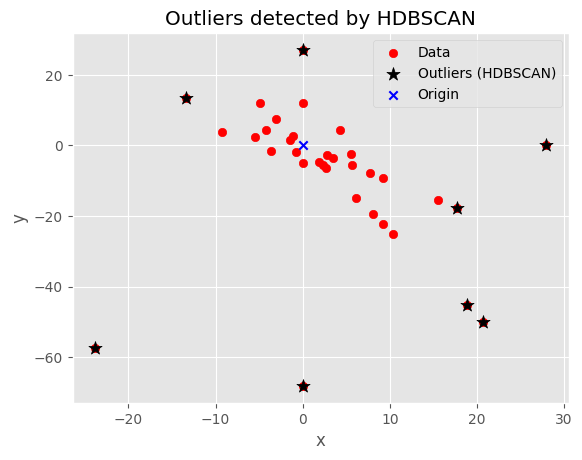

In [14]:
# define a function to get the outliers based on HDBSCAN
def get_hdbscan_outliers(min_cluster_size, min_samples):
	clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
	clusterer.fit(locs)
	# get the noise points
	noise_points_hdbscan = np.where(clusterer.labels_==-1)[0]
	return noise_points_hdbscan, len(noise_points_hdbscan)/len(locs)

# get the outliers based on HDBSCAN
hdbscan_outliers = []

# Example: Different values of min_cluster_size and min_samples to try
min_cluster_sizes = [2, 3, 4, 5]
min_samples = [1, 2, 3, 4, 5]


noise_count_threshold = 0.3
for i in min_cluster_sizes:
	for j in min_samples:
		noise_points_hdbscan, noise_ratio = get_hdbscan_outliers(i, j)
		# accept only if the algo does not classify too many points as noise
		if noise_ratio < noise_count_threshold:
			hdbscan_outliers.append(noise_points_hdbscan)
			print(f'The noise points detected by HDBSCAN with min_cluster_size={i} and min_samples={j}:',noise_points_hdbscan)
			print('The corresponding community names are:\n',df['Community Name'][noise_points_hdbscan])

		else:
			print(f'Too many noise points detected by HDBSCAN with min_cluster_size={i} and min_samples={j}:',noise_points_hdbscan)
			print('Skipping these parameters...')


print('The outliers detected by HDBSCAN are:',hdbscan_outliers)

majority_hdbscan_outliers = np.zeros(len(locs))

for i in range(len(hdbscan_outliers)):
	for outlier in hdbscan_outliers[i]:
		majority_hdbscan_outliers[outlier] += 1

# Select outliers that have the highest frequencies
# sort the outliers based on frequency
sorted_majority_hdbscan_outliers = np.argsort(majority_hdbscan_outliers)
print('The outliers sorted based on frequency are:', sorted_majority_hdbscan_outliers)
print('The corresponding community names are:\n', df['Community Name'][sorted_majority_hdbscan_outliers][::-1])

# select the top 8 outliers based on frequency
top_freq_outliers_HDBSCAN = sorted_majority_hdbscan_outliers[-8:]

# plot the outliers detected by HDBSCAN
plt.scatter(locs[:,0],locs[:,1],color='red')
plt.scatter(locs[list(top_freq_outliers_HDBSCAN),0],locs[list(top_freq_outliers_HDBSCAN),1],color='black', marker='*',s=100)
plt.scatter(origin[:,0],origin[:,1],color='blue', marker='x')
plt.legend(['Data','Outliers (HDBSCAN)','Origin'])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Outliers detected by HDBSCAN')
plt.show()



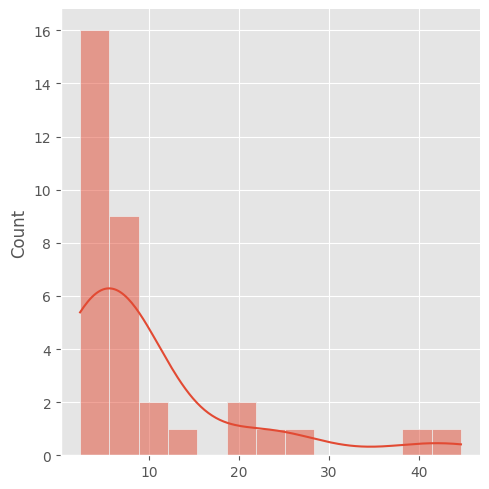

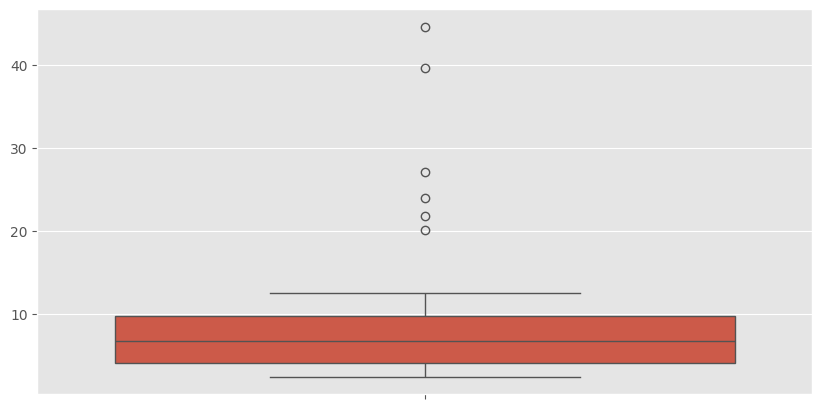

Number of outliers in terms of average distances: 6
Indices of the outliers: [ 2  3 21 22 26 31]
Threshold distance: 18.2589496219338


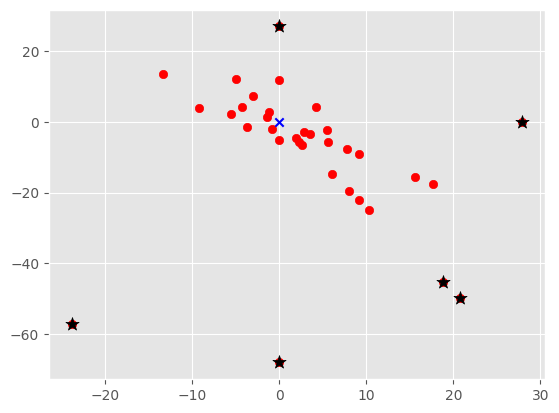

In [15]:
# Now, do the following: For each point take the top 5 nearest neighbors and calculate the average distance
# to these neighbors. Then, plot the histogram of these average distances.
# We will use the KDTree for this purpose
from scipy.spatial import KDTree
tree = KDTree(locs)
# get the 6 nearest neighbors (including the point itself)
distances, indices = tree.query(locs, k=8)
# calculate the average distance to the 5 nearest neighbors
avg_distances = np.mean(distances[:,1:], axis=1)
# plot the histogram of the average distances
sns.displot(avg_distances, kde=True)
plt.show()

# boxplot of the average distances
plt.figure(figsize=(10,5))
sns.boxplot(data=avg_distances)
plt.show()


# Find out the points for which the average distance to the 5 nearest neighbors is very high

IQR=np.percentile(avg_distances, [25, 75])
IQR_dist = IQR[1] - IQR[0]

threshold = IQR[1] + 1.5*IQR_dist
outliers_avg_dist = avg_distances > threshold
print('Number of outliers in terms of average distances:',np.sum(outliers_avg_dist))
print('Indices of the outliers:',np.where(outliers_avg_dist)[0])
print('Threshold distance:',threshold)

# highlight the outliers in the scatter plot
plt.scatter(locs[:,0],locs[:,1],color='red')
plt.scatter(locs[outliers_avg_dist,0],locs[outliers_avg_dist,1],color='black', marker='*',s=100)
plt.scatter(origin[:,0],origin[:,1],color='blue', marker='x')
plt.show()

In [16]:
# define a function to get the outliers based on average distances using the KDTree with varying k

def get_avg_dist_outliers(k):
	# threshold will be the 1.5*IQR above the 75th percentile
	distances, indices = tree.query(locs, k=k)
	# calculate the average distance to the k-1 nearest neighbors
	avg_distances = np.mean(distances[:,1:], axis=1)
	IQR=np.percentile(avg_distances, [25, 75])
	IQR_dist = IQR[1] - IQR[0]
	threshold = IQR[1] + 1.5*IQR_dist
	outliers_avg_dist = avg_distances > threshold
	# return the indices of the outliers
	return np.where(outliers_avg_dist)[0]

# get the outliers for k=6
outliers_avg_dist_k6 = get_avg_dist_outliers(6)
print('The outliers detected by average distance with k=6:',outliers_avg_dist_k6)

The outliers detected by average distance with k=6: [ 2  3 21 22 26 31]


In [17]:
# run the function for different values of k
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
outliers_avg_dist = []
for k in k_values:
	outliers_avg_dist.append(get_avg_dist_outliers(k))

# Count the frequency of each outlier across all values of k
outlier_freq = np.zeros(len(locs))
for outlier_list in outliers_avg_dist:
	for outlier in outlier_list:
		outlier_freq[outlier] += 1

# Select outliers that have the highest frequencies
# For example, we can choose outliers that appear in more than half of the k runs
threshold = len(k_values) // 2
max_freq_outliers = [i for i, freq in enumerate(outlier_freq) if freq > threshold]

top_kdtree_count=8
# argsort the outlier frequencies
sorted_outlier_freq = np.argsort(outlier_freq)
print('The outliers sorted based on frequency are:', sorted_outlier_freq[-top_kdtree_count:])
print('The corresponding community names are:\n', df['Community Name'][sorted_outlier_freq[-top_kdtree_count:]])


The outliers sorted based on frequency are: [33 32 21  2 31  3 26 22]
The corresponding community names are:
 33             Windsor
32           Waterways
21          Somerville
2          Craigieburn
31               Tyabb
3              Croydon
26    St Andrews Beach
22            Sorrento
Name: Community Name, dtype: object


In [18]:
# count the votes for each outlier from the different methods
# we will count the votes for each outlier from the different methods
votes = np.zeros(len(locs))
# add the votes from the LOF method
for outlier in top_freq_outliers_LOF:
	votes[outlier] += 1
# add the votes from the HDBSCAN method
for outlier in top_freq_outliers_HDBSCAN:
	votes[outlier] += 1

# add the votes from the KDTree method
for outlier in sorted_outlier_freq[-top_kdtree_count:]:
	votes[outlier] += 1

# add the votes from coordinate outliers
for outlier in coord_outliers:
	votes[outlier] += 1
	

print('The votes for each outlier are:',votes)

# select the outliers that have the most votes
threshold = 2
final_outliers = np.where(votes >= threshold)[0]
print('The final outliers are:',final_outliers)
print('The corresponding community names are:\n',df['Community Name'][final_outliers])

The votes for each outlier are: [0. 0. 3. 4. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 4. 4. 0.
 0. 0. 4. 0. 0. 0. 0. 4. 1. 1.]
The final outliers are: [ 2  3  9 21 22 26 31]
The corresponding community names are:
 2           Craigieburn
3               Croydon
9     Melbourne Airport
21           Somerville
22             Sorrento
26     St Andrews Beach
31                Tyabb
Name: Community Name, dtype: object


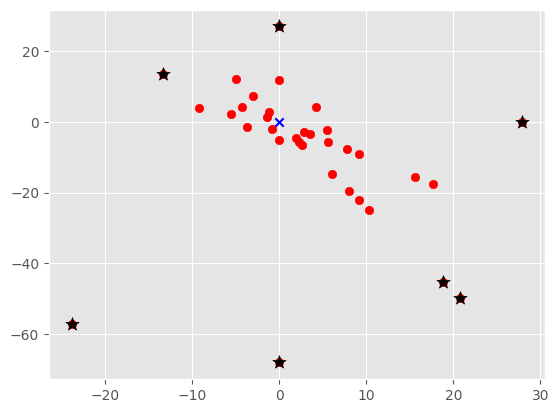

In [19]:
# plot the final outliers
plt.scatter(locs[:,0],locs[:,1],color='red')
plt.scatter(locs[final_outliers,0],locs[final_outliers,1],color='black', marker='*',s=100)
plt.scatter(origin[:,0],origin[:,1],color='blue', marker='x')
plt.show()

In [20]:
final_outliers

array([ 2,  3,  9, 21, 22, 26, 31])

The mapping of the indices between the original and the filtered data is: [ 0  1  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19 20 23 24 25 27 28 29
 30 32 33]


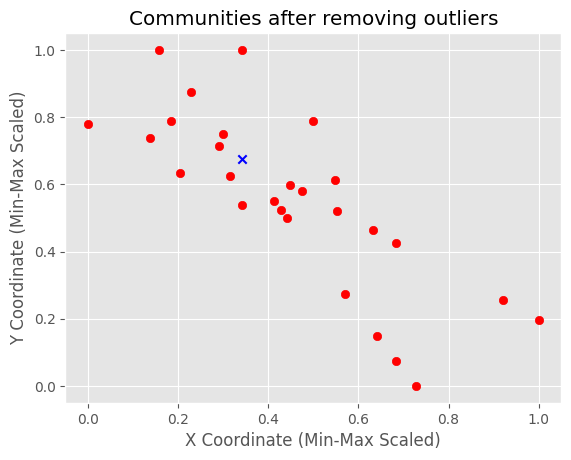

In [71]:
# drop the outliers and re-run the clustering
locs_filtered = np.delete(locs, final_outliers, axis=0)
# find out the mapping of the indices between the original and the filtered data
mapping = np.arange(len(locs))
mapping = np.delete(mapping, final_outliers)
map_dict = {i: mapping[i] for i in range(len(mapping))}
print('The mapping of the indices between the original and the filtered data is:',mapping)
# re-scale the points
scaler_filtered = sk.preprocessing.MinMaxScaler()
locs_filtered = scaler_filtered.fit_transform(locs_filtered)
# re-scale the origin
origin_scaled = scaler_filtered.transform(origin)
# clusterer_filtered = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True, min_samples=1, cluster_selection_epsilon=0.5)
# clusterer_filtered.fit(locs_filtered)

# plot the clusters
plt.scatter(locs_filtered[:,0],locs_filtered[:,1],color='red')
plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
# highlight the noise points
# plt.scatter(locs_filtered[clusterer_filtered.labels_==-1,0],locs_filtered[clusterer_filtered.labels_==-1,1],color='black', marker='*',s=100)
# # annotate each point with the corresponding cluster label
# for i in range(len(locs_filtered)):
# 	plt.annotate(clusterer_filtered.labels_[i], (locs_filtered[i,0],locs_filtered[i,1]), size=6)

plt.title('Communities after removing outliers')
plt.xlabel('X Coordinate (Min-Max Scaled)')
plt.ylabel('Y Coordinate (Min-Max Scaled)')
plt.show()


Eigenvalues of the Laplacian matrix: [-0.65353254 -0.19974157 -0.14598048  0.75934639  0.85092938  1.58578644
  1.60050314  1.70495999  2.1914881   2.50500569  2.92890093  3.
  3.25565865  3.34155213  3.57695626  3.71698248  4.          4.1604903
  4.30212027  4.34283181  4.41421356  4.64236773  4.67291129  4.82194819
  5.09363941  5.24351808  5.28714435]


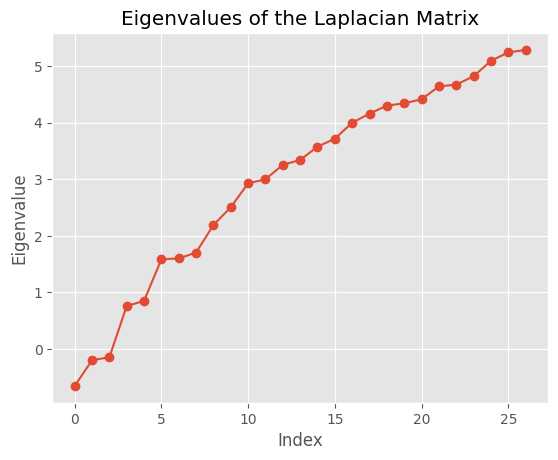

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import normalize
from scipy.linalg import eigh
from sklearn.metrics import pairwise_distances

# Assume locs_filtered contains your filtered location data (e.g., latitude and longitude)
# Generate the affinity matrix using nearest neighbors
n_neighbors = 4  # Same as used in SpectralClustering
affinity_matrix = kneighbors_graph(locs_filtered, n_neighbors=n_neighbors, include_self=True).toarray()

# Compute the Laplacian matrix (unnormalized or normalized)
from sklearn.metrics.pairwise import pairwise_kernels
laplacian = np.diag(np.sum(affinity_matrix, axis=1)) - affinity_matrix

# Eigen decomposition of the Laplacian matrix
# eigh returns sorted eigenvalues and eigenvectors
eigenvalues, eigenvectors = eigh(laplacian)

# Output the eigenvalues
print("Eigenvalues of the Laplacian matrix:", eigenvalues)

# Optional: Visualize the first few eigenvectors if needed
plt.plot(eigenvalues, marker='o')
plt.title('Eigenvalues of the Laplacian Matrix')
plt.xlabel('Index')
plt.ylabel('Eigenvalue')
plt.show()


The indices of the largest jumps in eigenvalues are: [np.int64(18), np.int64(15), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2), np.int64(2)]


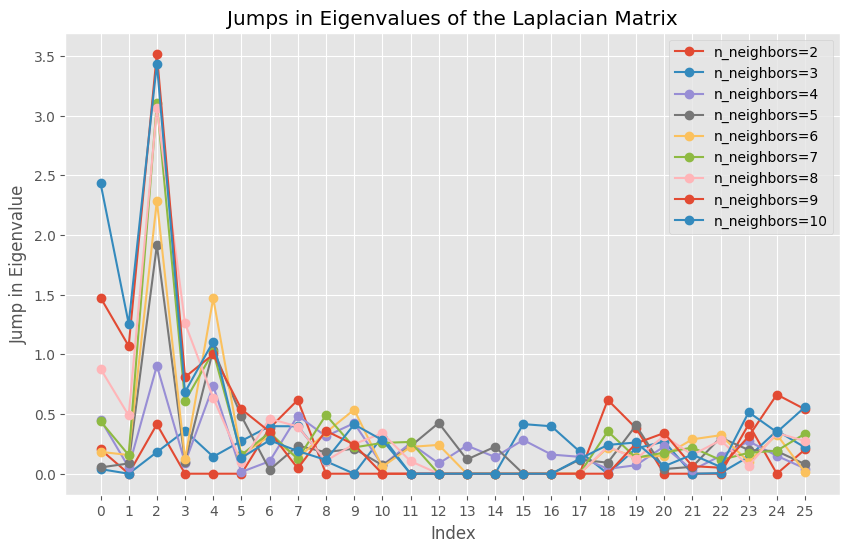

The most common index with the largest jump in eigenvalues is: 2
The optimal number of clusters is: 3


In [23]:
# define a function to get the jump in eigenvalues, with varying n_neighbors
def get_eigenvalue_jump(n_neighbors):
	affinity_matrix = kneighbors_graph(locs_filtered, n_neighbors=n_neighbors, include_self=True).toarray()
	laplacian = np.diag(np.sum(affinity_matrix, axis=1)) - affinity_matrix
	eigenvalues, eigenvectors = eigh(laplacian)
	# sort the eigenvalues
	eigenvalues = np.sort(eigenvalues)
	# get the jump in eigenvalues
	jumps = np.diff(eigenvalues)
	return jumps

# get the jump in eigenvalues for different values of n_neighbors
n_neighbors_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
eigenvalue_jumps = []
for n in n_neighbors_values:
	eigenvalue_jumps.append(get_eigenvalue_jump(n))

# figure out where the jump in eigenvalues is the largest for each n_neighbors
max_jumps = [np.argmax(jumps) for jumps in eigenvalue_jumps]
print('The indices of the largest jumps in eigenvalues are:',max_jumps)

# plot the jumps in eigenvalues for each n_neighbors
plt.figure(figsize=(10, 6))
for i in range(len(n_neighbors_values)):
	plt.plot(eigenvalue_jumps[i], marker='o', label=f'n_neighbors={n_neighbors_values[i]}')
plt.title('Jumps in Eigenvalues of the Laplacian Matrix')
plt.xlabel('Index')
plt.ylabel('Jump in Eigenvalue')
plt.xticks(range(len(eigenvalue_jumps[0])), range(0, len(eigenvalue_jumps[0])))
plt.legend()
plt.show()

# count how many times each index was the maximum jump
max_jumps = np.array(max_jumps)
unique, counts = np.unique(max_jumps, return_counts=True)
max_jumps = dict(zip(unique, counts))

# get the index with the most number of times as the maximum jump
most_common_index = max(max_jumps, key=max_jumps.get)
print('The most common index with the largest jump in eigenvalues is:',most_common_index)

# print the conclusion in terms of optimal cluster number
print('The optimal number of clusters is:',most_common_index+1)


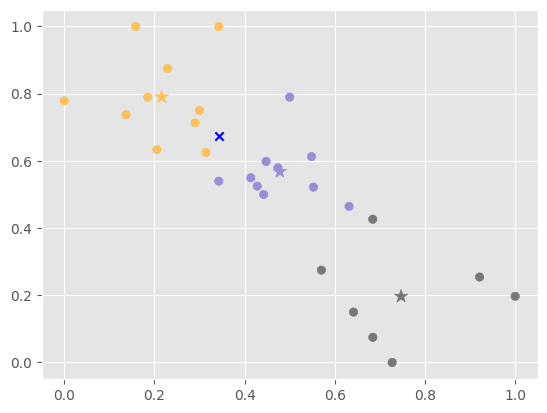

In [94]:
# run spectral clustering on the locational data
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=3, affinity='nearest_neighbors', n_neighbors=5)
spectral.fit(locs_filtered)

# plot the clusters
plt.scatter(locs_filtered[:,0],locs_filtered[:,1],c=[f'C{label+9}' for label in spectral.labels_])
plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
# plot the centroids_spectral
centroids_spectral = np.zeros((3,2))
for i in range(3):
	centroids_spectral[i] = np.mean(locs_filtered[spectral.labels_==i], axis=0)
plt.scatter(centroids_spectral[:,0],centroids_spectral[:,1],color=[f'C{i+9}' for i in range(3)],marker='*',s=100)
plt.show()



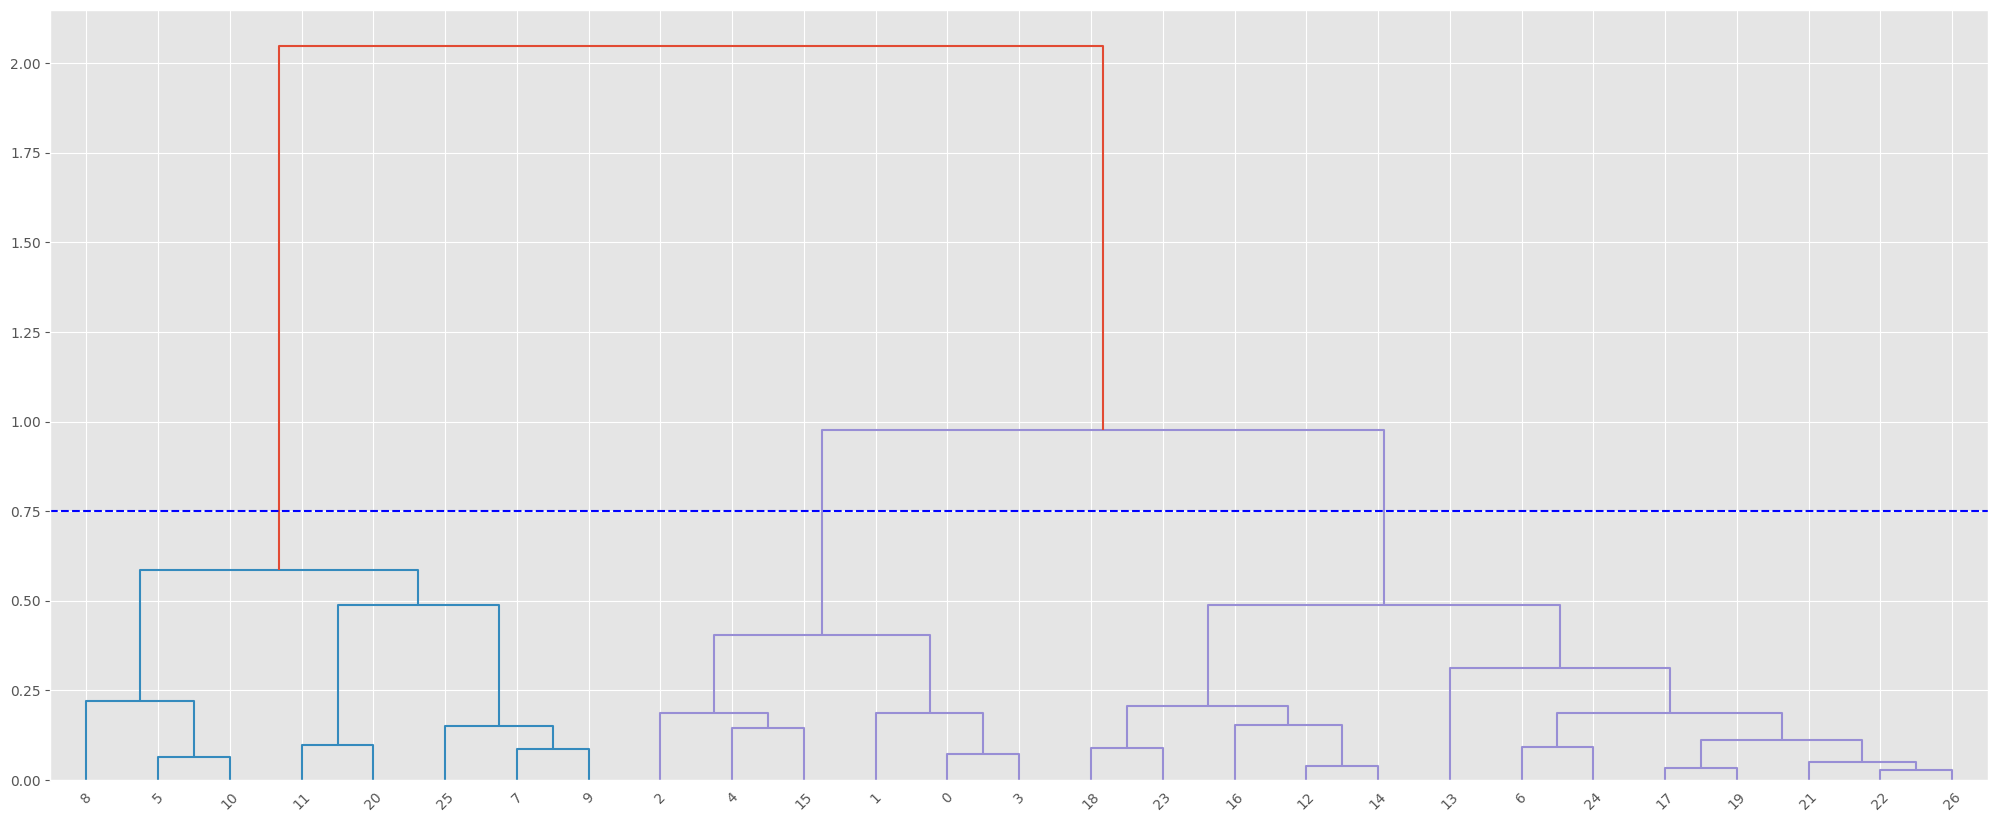

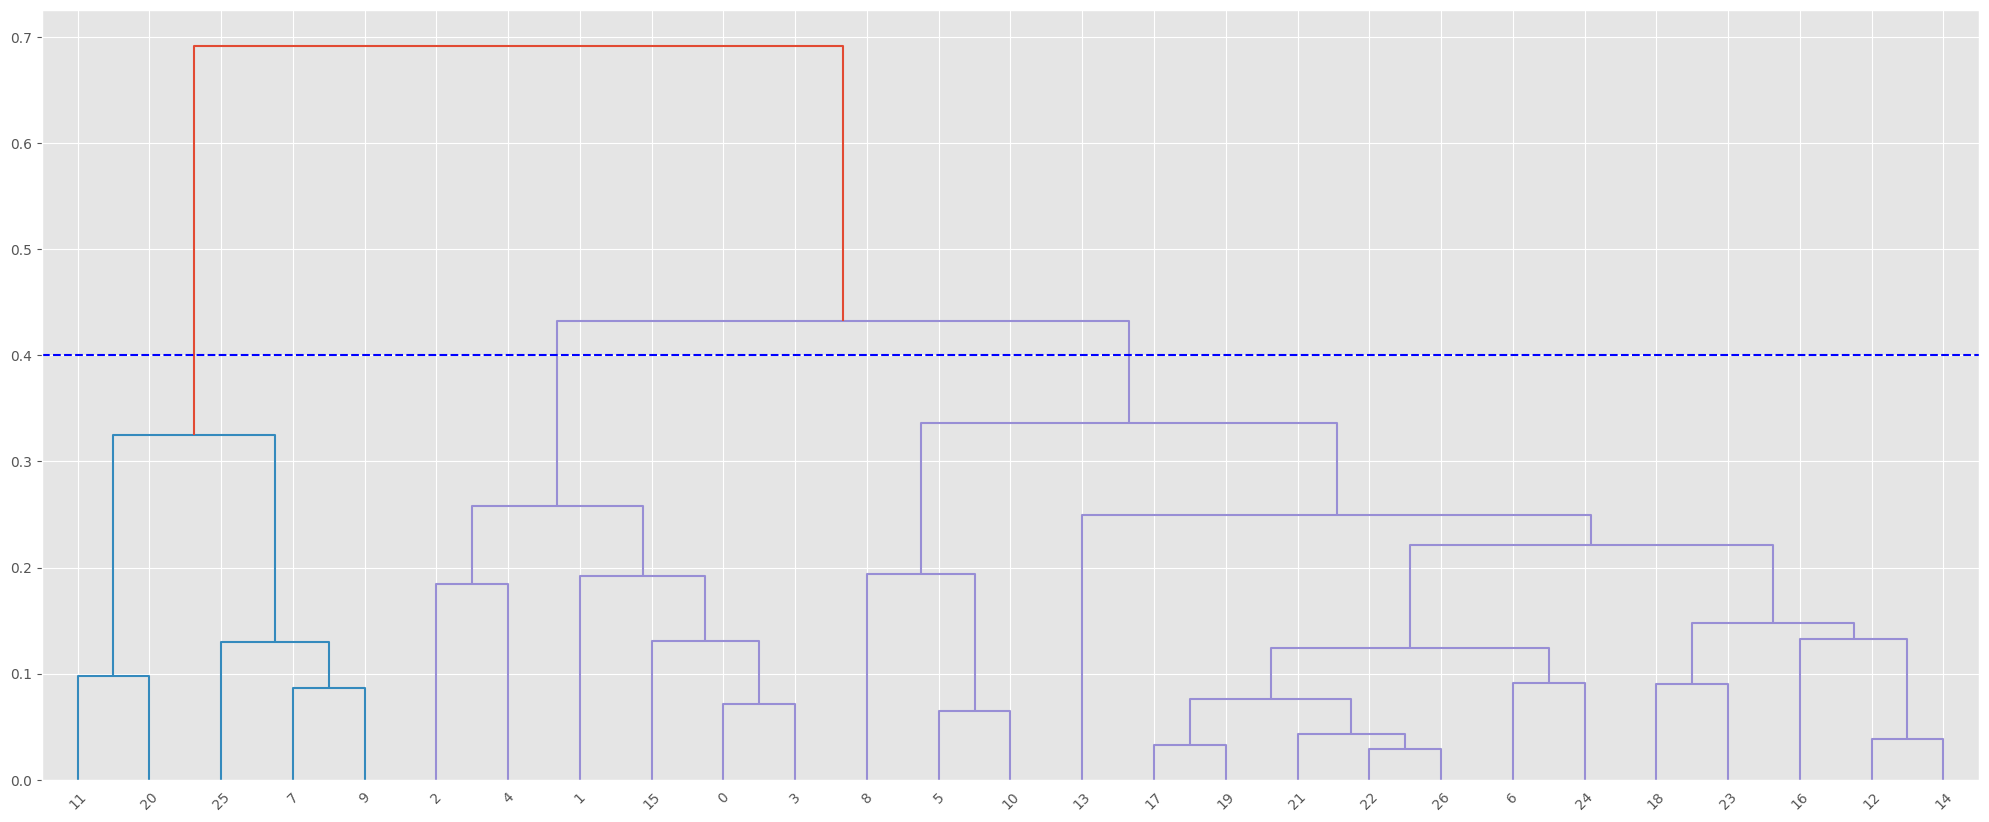

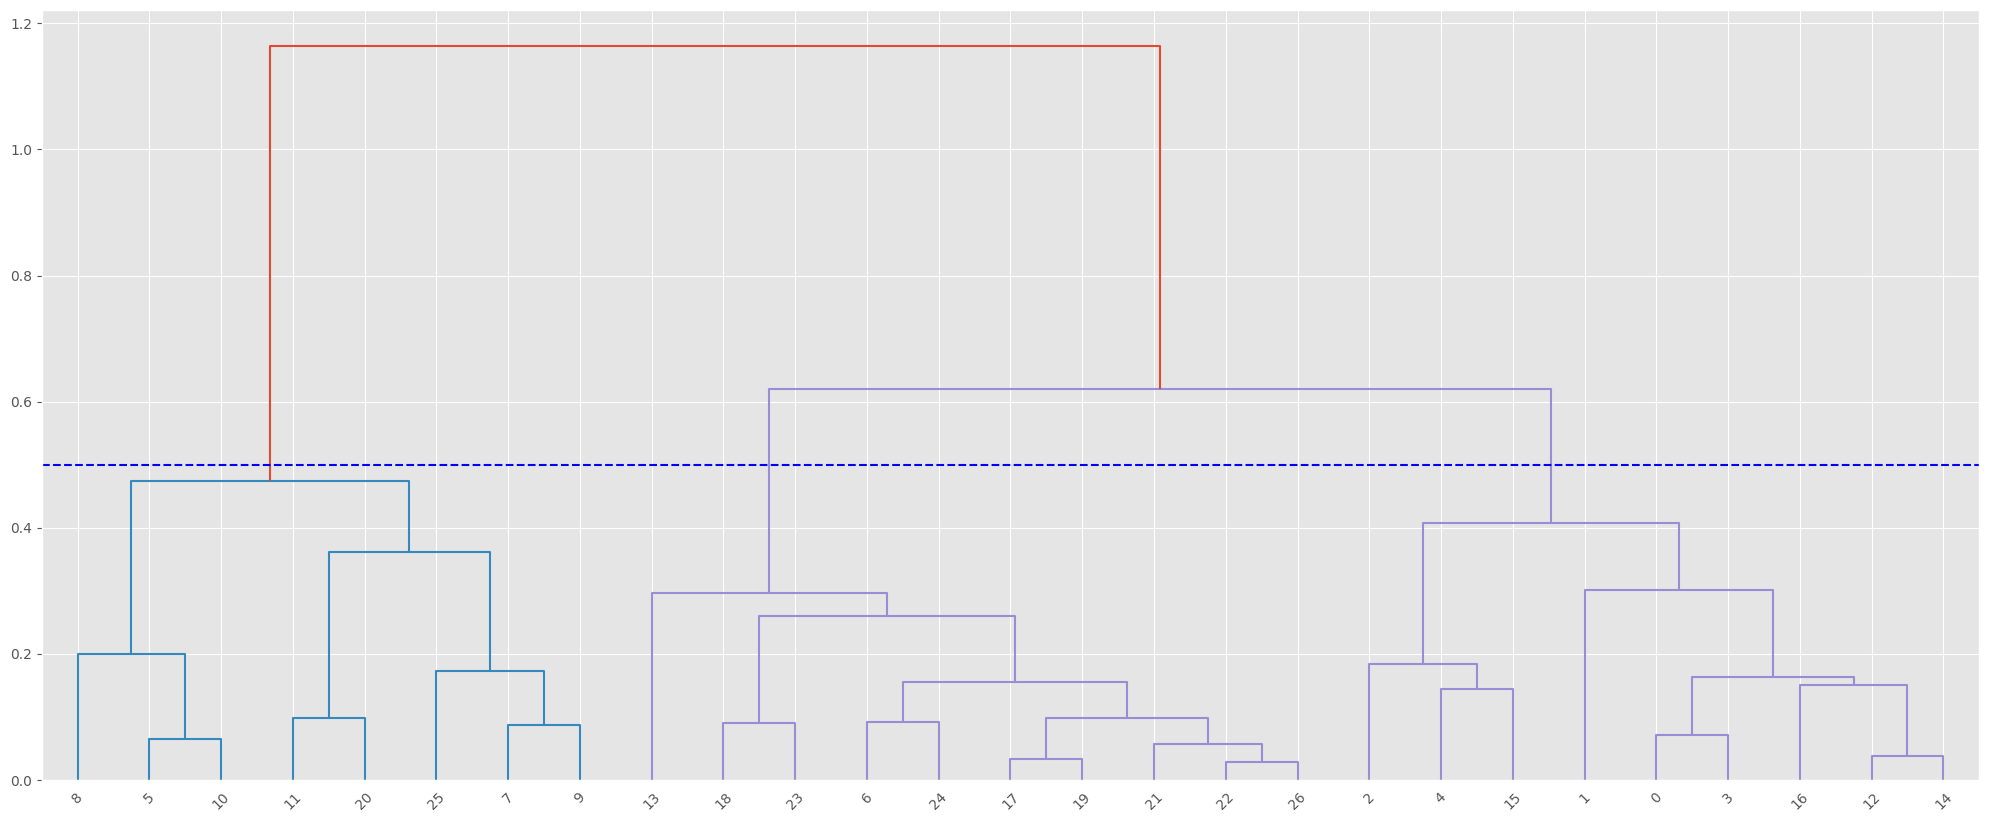

In [101]:
# show the dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage
Z = linkage(locs_filtered, 'ward')
plt.figure(figsize=(25, 10))
dendrogram(Z)
# draw a horizontal line at y=0.75
plt.axhline(y=0.75, color='b', linestyle='--')
plt.show()

# show linkage based on average distance
Z_avg = linkage(locs_filtered, 'average')
plt.figure(figsize=(25, 10))
dendrogram(Z_avg)
# draw a horizontal line at y=0.4
plt.axhline(y=0.4, color='b', linestyle='--')
plt.show()

# show linkage based on complete distance
Z_complete = linkage(locs_filtered, 'complete')
plt.figure(figsize=(25, 10))
dendrogram(Z_complete)
# draw a horizontal line at y=0.4
plt.axhline(y=0.5, color='b', linestyle='--')
plt.show()

The evaluation scores for linkage method ward are: (np.float64(0.42891505703300786), np.float64(43.925218257190586), np.float64(0.7228103287362657))
The evaluation scores for linkage method average are: (np.float64(0.4093166316098958), np.float64(38.82666206310298), np.float64(0.6658820996022748))
The evaluation scores for linkage method complete are: (np.float64(0.4330650163524465), np.float64(46.927149134938276), np.float64(0.6838891392113616))
The evaluation scores for linkage method single are: (np.float64(0.5011298901486023), np.float64(20.60055963150351), np.float64(0.4921914330865163))


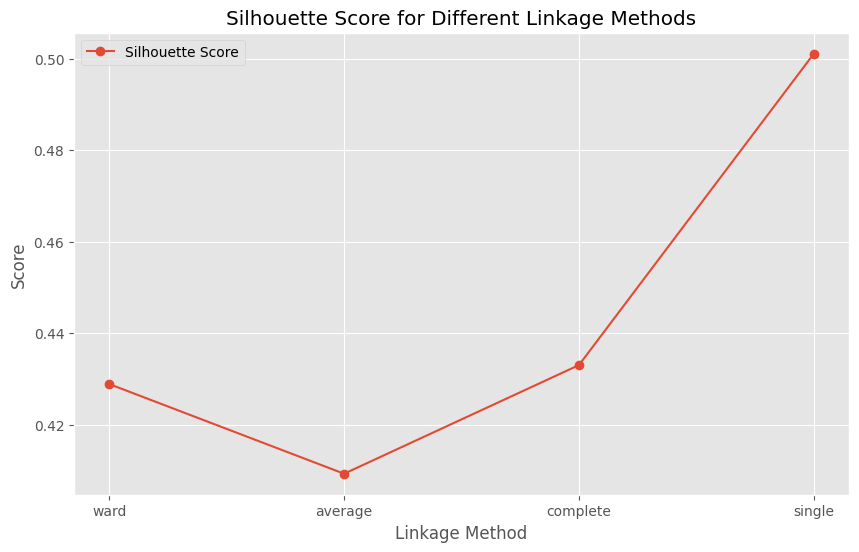

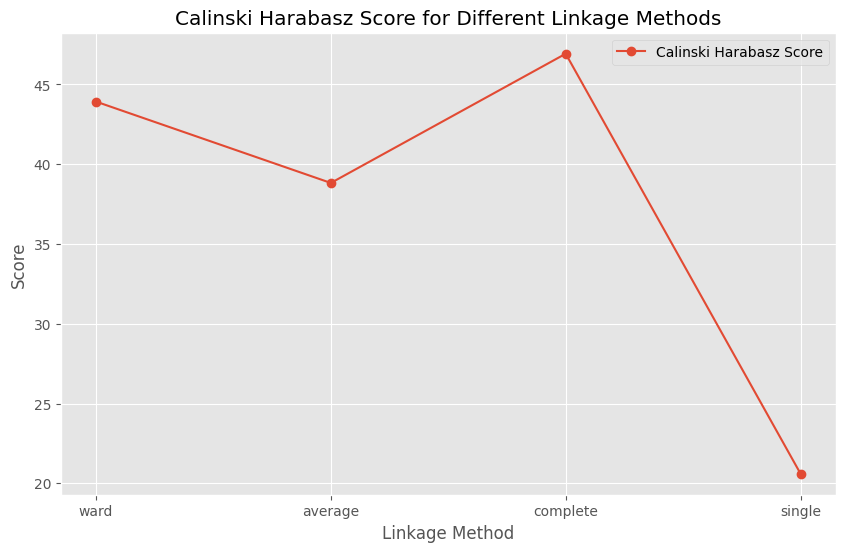

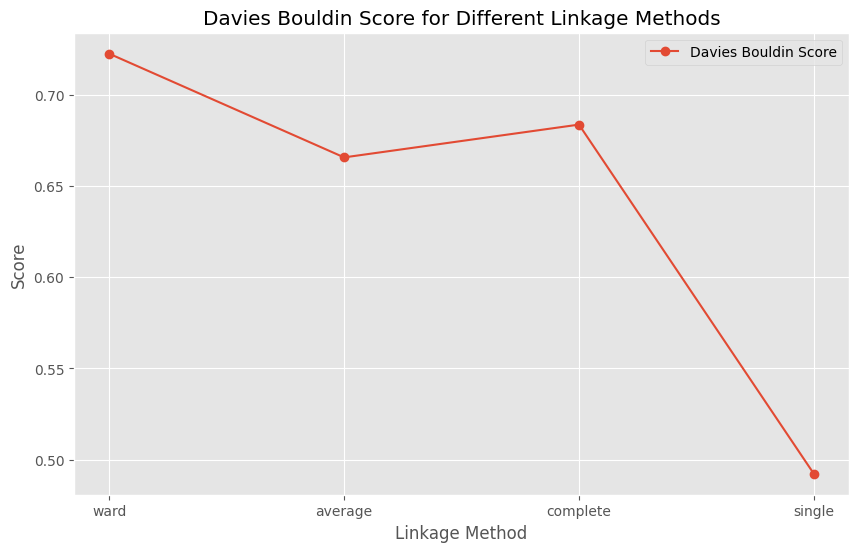

In [113]:
# Evaluate the different linkage methods using
# silhouette score, calinski harabasz score, and davies bouldin score
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering

# define a function to evaluate the different linkage methods
def evaluate_linkage(linkage_method):
	# fit the agglomerative clustering model
	agg = AgglomerativeClustering(n_clusters=3, linkage=linkage_method)
	agg.fit(locs_filtered)
	# get the silhouette score
	silhouette = silhouette_score(locs_filtered, agg.labels_)
	# get the calinski harabasz score
	calinski = calinski_harabasz_score(locs_filtered, agg.labels_)
	# get the davies bouldin score
	davies = davies_bouldin_score(locs_filtered, agg.labels_)
	return silhouette, calinski, davies

# evaluate the different linkage methods
linkage_methods = ['ward', 'average', 'complete', 'single']
evaluation_scores = []
for method in linkage_methods:
	evaluation_scores.append(evaluate_linkage(method))

# print the evaluation scores
for i in range(len(linkage_methods)):
	print(f'The evaluation scores for linkage method {linkage_methods[i]} are:',evaluation_scores[i])

# plot the evaluation scores
silhouette_scores = [score[0] for score in evaluation_scores]
calinski_scores = [score[1] for score in evaluation_scores]
davies_scores = [score[2] for score in evaluation_scores]

plt.figure(figsize=(10, 6))
plt.plot(linkage_methods, silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel('Linkage Method')
plt.ylabel('Score')
plt.title('Silhouette Score for Different Linkage Methods')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(linkage_methods, calinski_scores, marker='o', label='Calinski Harabasz Score')
plt.xlabel('Linkage Method')
plt.ylabel('Score')
plt.title('Calinski Harabasz Score for Different Linkage Methods')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(linkage_methods, davies_scores, marker='o', label='Davies Bouldin Score')
plt.xlabel('Linkage Method')
plt.ylabel('Score')
plt.title('Davies Bouldin Score for Different Linkage Methods')
plt.legend()
plt.show()



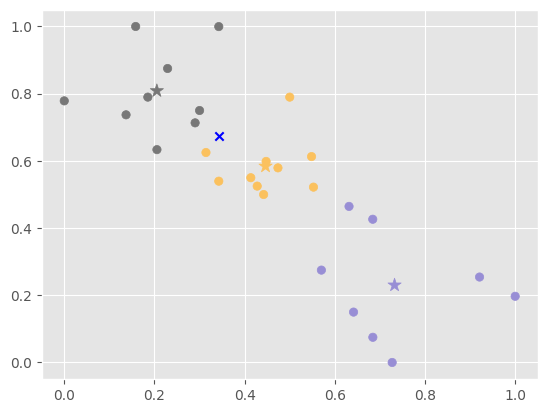

In [123]:
# try hierarchical clustering on the filtered locational data
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=3, linkage='complete', metric='euclidean')
agg.fit(locs_filtered)

# plot the clusters
plt.style.use('ggplot')
plt.scatter(locs_filtered[:,0],locs_filtered[:,1],c=[f'C{label+9}' for label in agg.labels_])
plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
# plot the centroids_hier
centroids_hier = np.zeros((3,2))
for i in range(3):
	centroids_hier[i] = np.mean(locs_filtered[agg.labels_==i], axis=0)

plt.scatter(centroids_hier[:,0],centroids_hier[:,1],color=[f'C{i+9}' for i in range(3)],marker='*',s=100)
plt.show()

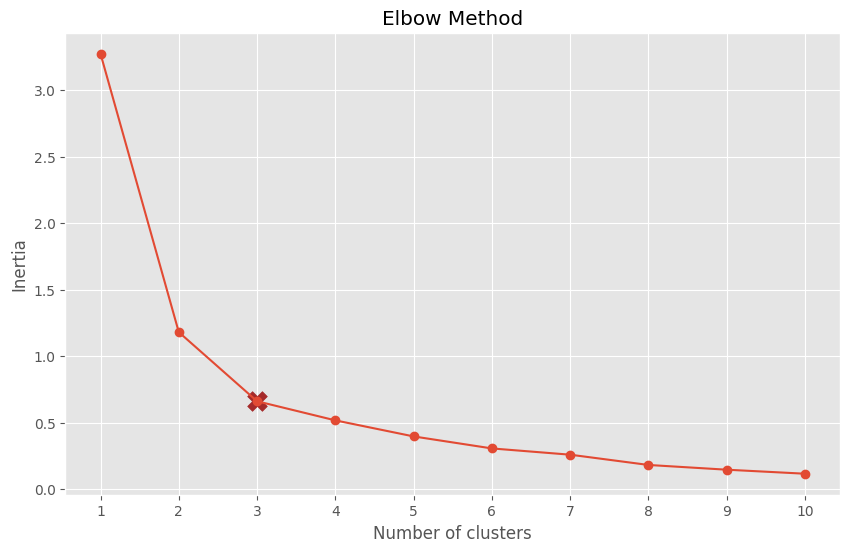

In [124]:
# try k-means clustering on the filtered locational data
from sklearn.cluster import KMeans
# run elbow method to determine the optimal number of clusters
inertia = []
for i in range(1, 11):
	kmeans = KMeans(n_clusters=i, random_state=0).fit(locs_filtered)
	inertia.append(kmeans.inertia_)

# try different themes

plt.figure(figsize=(10, 6))

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))

# place a cross at the optimal number of clusters
plt.scatter(3, inertia[2], color='brown', marker='X', s=200)
plt.show()




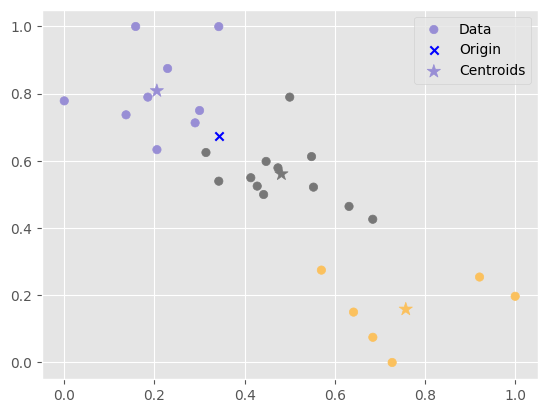

In [125]:
# try k-means clustering on the filtered locational data
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0, n_init=100)
kmeans.fit(locs_filtered)


plt.scatter(locs_filtered[:,0],locs_filtered[:,1],c=[f'C{label+9}' for label in kmeans.labels_])
plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
# show the centroids
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color=[f'C{i+9}' for i in range(3)],marker='*',s=100)

plt.legend(['Data','Origin','Centroids'])
plt.show()


In [126]:
# compute NMI between the hierarchical clustering and the k-means clustering
from sklearn.metrics.cluster import normalized_mutual_info_score
nmi = normalized_mutual_info_score(agg.labels_, kmeans.labels_)
print('NMI between hierarchical clustering and k-means clustering:',nmi)


# compute NMI between the hierarchical clustering and the spectral clustering
nmi = normalized_mutual_info_score(agg.labels_, spectral.labels_)
print('NMI between hierarchical clustering and spectral clustering:',nmi)

# compute NMI between the k-means clustering and the spectral clustering
nmi = normalized_mutual_info_score(kmeans.labels_, spectral.labels_)
print('NMI between k-means clustering and spectral clustering:',nmi)



NMI between hierarchical clustering and k-means clustering: 0.8297872676023633
NMI between hierarchical clustering and spectral clustering: 0.7831224705508028
NMI between k-means clustering and spectral clustering: 0.7771705617887947


In [127]:
# Compute ARI between the hierarchical clustering and the k-means clustering
from sklearn.metrics.cluster import adjusted_rand_score
ari = adjusted_rand_score(agg.labels_, kmeans.labels_)
print('ARI between hierarchical clustering and k-means clustering:',ari)

# Compute ARI between the hierarchical clustering and the spectral clustering
ari = adjusted_rand_score(agg.labels_, spectral.labels_)
print('ARI between hierarchical clustering and spectral clustering:',ari)

# Compute ARI between the k-means clustering and the spectral clustering
ari = adjusted_rand_score(kmeans.labels_, spectral.labels_)
print('ARI between k-means clustering and spectral clustering:',ari)

ARI between hierarchical clustering and k-means clustering: 0.7913043478260869
ARI between hierarchical clustering and spectral clustering: 0.7749236166119724
ARI between k-means clustering and spectral clustering: 0.7662337662337663


In [128]:
agg.labels_, kmeans.labels_, spectral.labels_

(array([1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 2, 2, 2, 0, 2,
        2, 2, 2, 0, 2]),
 array([0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 1, 2, 0, 1, 0, 0, 0, 1, 1, 1, 2, 1,
        1, 1, 1, 2, 1], dtype=int32),
 array([2, 2, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 0, 2, 0, 1, 0,
        0, 0, 0, 1, 0], dtype=int32))

The best matching between the cluster labels (spectral and k-means) is: [0 1 2] [1 2 0]
The best matching between the cluster labels (hierarchical and k-means) is: [0 1 2] [2 0 1]
The best matching between the cluster labels (hierarchical and spectral) is: [0 1 2] [1 2 0]
{0: [np.float64(0.0), np.float64(0.0), np.float64(0.0)], 1: [np.float64(0.0), np.float64(0.0), np.float64(0.0)], 2: [np.float64(0.0), np.float64(0.0), np.float64(0.0)], 3: [np.float64(0.0), np.float64(0.0), np.float64(0.0)], 4: [np.float64(0.0), np.float64(0.0), np.float64(0.0)], 5: [np.float64(1.0), np.float64(1.0), np.float64(2.0)], 6: [np.float64(1.0), np.float64(1.0), np.float64(1.0)], 7: [np.float64(2.0), np.float64(2.0), np.float64(2.0)], 8: [np.float64(2.0), np.float64(2.0), np.float64(2.0)], 9: [np.float64(2.0), np.float64(2.0), np.float64(2.0)], 10: [np.float64(2.0), np.float64(1.0), np.float64(2.0)], 11: [np.float64(2.0), np.float64(2.0), np.float64(2.0)], 12: [np.float64(0.0), np.float64(0.0), np.float64(0.

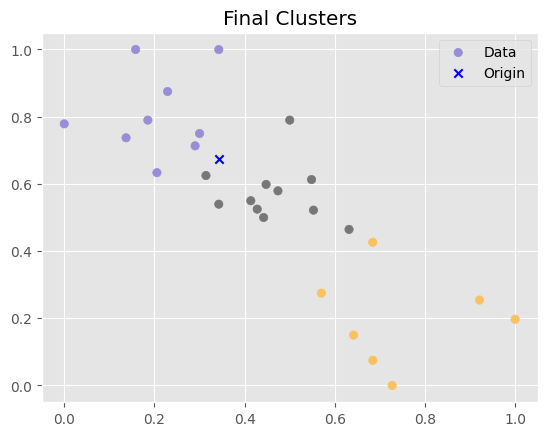

In [129]:
# do a majority voting to get the final cluster labels
votes = np.zeros(len(locs_filtered))
# do hungarian matching to get the best matching between the cluster labels
from scipy.optimize import linear_sum_assignment
# create a cost matrix
cost_matrix_spec_kmeans = np.zeros((3,3))
for i in range(3):
	for j in range(3):
		cost_matrix_spec_kmeans[i,j] = np.sum((spectral.labels_ == i) & (kmeans.labels_ == j))

row_ind_spec_kmeans, col_ind_spec_kmeans = linear_sum_assignment(-cost_matrix_spec_kmeans)
print('The best matching between the cluster labels (spectral and k-means) is:',row_ind_spec_kmeans, col_ind_spec_kmeans)

# do hungarian matching between hierarchical clustering and k-means clustering
# get the best matching between the cluster labels

cost_matrix_hier_kmeans = np.zeros((3,3))
for i in range(3):
	for j in range(3):
		cost_matrix_hier_kmeans[i,j] = np.sum((agg.labels_ == i) & (kmeans.labels_ == j))

row_ind_hier_kmeans, col_ind_hier_kmeans = linear_sum_assignment(-cost_matrix_hier_kmeans)
print('The best matching between the cluster labels (hierarchical and k-means) is:',row_ind_hier_kmeans, col_ind_hier_kmeans)

# do hungarian matching between hierarchical clustering and spectral clustering
# get the best matching between the cluster labels

cost_matrix_hier_spec = np.zeros((3,3))
for i in range(3):
	for j in range(3):
		cost_matrix_hier_spec[i,j] = np.sum((agg.labels_ == i) & (spectral.labels_ == j))

row_ind_hier_spec, col_ind_hier_spec = linear_sum_assignment(-cost_matrix_hier_spec)
print('The best matching between the cluster labels (hierarchical and spectral) is:',row_ind_hier_spec, col_ind_hier_spec)

# get the final cluster labels
final_labels = np.zeros(len(locs_filtered))
# remapped labels for spectral clustering
spectral_labels_remapped = np.zeros(3)
for i in range(3):
	spectral_labels_remapped[i] = col_ind_spec_kmeans[i]

# remapped labels for k-means clustering
kmeans_labels_remapped = np.zeros(3)
for i in range(3):
	kmeans_labels_remapped[i] = row_ind_spec_kmeans[i]

# remapped labels for hierarchical clustering
hier_labels_remapped = np.zeros(3)
for i in range(3):
	hier_labels_remapped[i] = col_ind_hier_kmeans[i]

vote_count_dict = {i:[] for i in range(locs_filtered.shape[0])}
# get the final cluster labels
for i in range(locs_filtered.shape[0]):
	vote_count_dict[i].append(spectral_labels_remapped[spectral.labels_[i]])
	vote_count_dict[i].append(kmeans_labels_remapped[kmeans.labels_[i]])
	vote_count_dict[i].append(hier_labels_remapped[agg.labels_[i]])


print(vote_count_dict)

# get the final cluster labels
for i in range(locs_filtered.shape[0]):
	final_labels[i] = max(vote_count_dict[i], key=vote_count_dict[i].count)

print(final_labels)

# plot the final clusters
plt.scatter(locs_filtered[:,0],locs_filtered[:,1],c=[f'C{int(label)+9}' for label in final_labels])
plt.scatter(origin_scaled[:,0],origin_scaled[:,1],color='blue', marker='x')
plt.title('Final Clusters')
plt.legend(['Data','Origin'])
plt.show()


In [130]:
final_labels

array([0., 0., 0., 0., 0., 1., 1., 2., 2., 2., 2., 2., 0., 1., 0., 0., 0.,
       1., 1., 1., 2., 1., 1., 1., 1., 2., 1.])

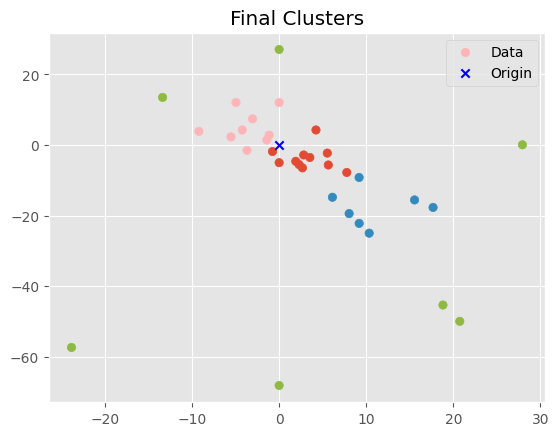

In [137]:
# assign the final cluster labels to the original data
# get the final cluster labels
final_labels_orig = np.zeros(len(locs))
for i in range(len(final_labels)):
	final_labels_orig[map_dict[i]] = final_labels[i]

# assign the outlier labels
for outlier in final_outliers:
	final_labels_orig[outlier] = -1

# plot the final clusters
plt.scatter(locs[:,0],locs[:,1],c=[f'C{int(label)+6}' for label in final_labels_orig])
plt.scatter(0,0,color='blue', marker='x')
plt.title('Final Clusters')
plt.legend(['Data','Origin'])
plt.show()

In [139]:
# save the final cluster labels to a csv file
df['Cluster Label'] = final_labels_orig.astype(int)
df.to_csv('final_clusters.csv', index=False)

df.head()

,Community Name,Region,Map reference,Grid reference,Location,Population Density,Travel time to GPO (minutes),Distance to GPO (km),LGA,Primary Care Partnership,...,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %",geo_lat,geo_lon,cart_x,cart_y,Cluster Label
0,Ascot Vale,Northern and Western Metropolitan,4,B3,6km NW of Melbourne,3758.623596,9.360142,6.958742,Moonee Valley (C),Inner North West Primary Care Partnership,...,4.993841,679.257076,20.502456,1864.918123,56.290032,-37.775606,144.914871,-4.230377,4.251470,0
1,Braybrook,Northern and Western Metropolitan,4,A3,10km WNW of Melbourne,2025.468296,15.131666,11.595888,Maribyrnong (C),"HealthWest (b): Hobson's Bay, Maribyrnong, Wyn...",...,10.161988,543.631989,20.647263,1683.966712,63.957428,-37.779315,144.858155,-9.212552,3.839001,0
2,Craigieburn,Northern and Western Metropolitan,2,A3,27km N of Melbourne,1034.970870,31.994666,43.100287,Hume (C),Hume-Whittlesea Primary Care Partnership,...,15.213189,2044.424399,20.618005,5102.134434,51.454988,-37.570576,144.963028,0.000000,27.049690,-1
3,Croydon,Eastern Metropolitan,2,B4,28km E of Melbourne,1730.064830,28.992647,34.071323,Maroondah (C),Outer East Primary Care Partnership,...,3.601752,1754.954941,28.537825,3062.182462,49.795026,-37.813411,145.281013,27.933349,0.047723,-1
4,Fawkner,Northern and Western Metropolitan,4,C1,12km N of Melbourne,2619.120089,17.405267,13.047142,Moreland (C),Inner North West Primary Care Partnership,...,12.004044,680.401318,17.909865,1942.874353,51.141315,-37.705724,144.963028,0.000000,12.021947,0


In [142]:
df_clustered = pd.read_csv('final_clusters.csv')

df_clustered['Cluster']=df_clustered['Cluster Label']+1

In [143]:
# group 'Populationi Density' by 'Cluster'
df_clustered.groupby('Cluster')['Population Density'].describe()

# Check if the clusters are statistically different in terms of 'Population Density'
from scipy.stats import f_oneway
cluster_0 = df_clustered[df_clustered['Cluster']==0]['Population Density']
cluster_1 = df_clustered[df_clustered['Cluster']==1]['Population Density']
cluster_2 = df_clustered[df_clustered['Cluster']==2]['Population Density']
cluster_3 = df_clustered[df_clustered['Cluster']==3]['Population Density']
f_oneway(cluster_0, cluster_1, cluster_2, cluster_3)



F_onewayResult(statistic=np.float64(22.00931315236673), pvalue=np.float64(9.924006568865463e-08))

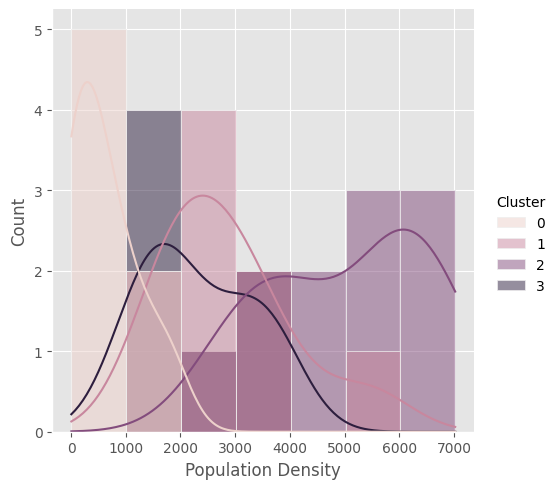

In [144]:
df_clustered.groupby('Cluster')['Population Density'].describe()

# plot the distribution of 'Population Density' for each cluster
sns.displot(df_clustered, x='Population Density', hue='Cluster', kde=True)
plt.show()

In [145]:
# conduct Tukey's HSD test to determine which clusters are different
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
mc = MultiComparison(df_clustered['Population Density'], df_clustered['Cluster'])
result = mc.tukeyhsd()
print(result)


    Multiple Comparison of Means - Tukey HSD, FWER=0.05     
group1 group2  meandiff  p-adj    lower      upper    reject
------------------------------------------------------------
     0      1  2246.8604 0.0033    646.918  3846.8029   True
     0      2  4449.8397    0.0  2914.8498  5984.8297   True
     0      3  1716.9056 0.0466    19.9104  3413.9009   True
     1      2  2202.9793 0.0012   776.0185  3629.9402   True
     1      3  -529.9548 0.8045 -2129.8973  1069.9877  False
     2      3 -2732.9341 0.0002 -4267.9241 -1197.9442   True
------------------------------------------------------------


In [204]:
# conduct dunn's test to determine which clusters are different
from scikit_posthocs import posthoc_dunn
results_dunn=posthoc_dunn(df_clustered, val_col='Population Density', group_col='Cluster', p_adjust='holm')
print(results_dunn)




          0         1         2         3
0  1.000000  0.041256  0.000011  0.113427
1  0.041256  1.000000  0.072070  0.586427
2  0.000011  0.072070  1.000000  0.038497
3  0.113427  0.586427  0.038497  1.000000


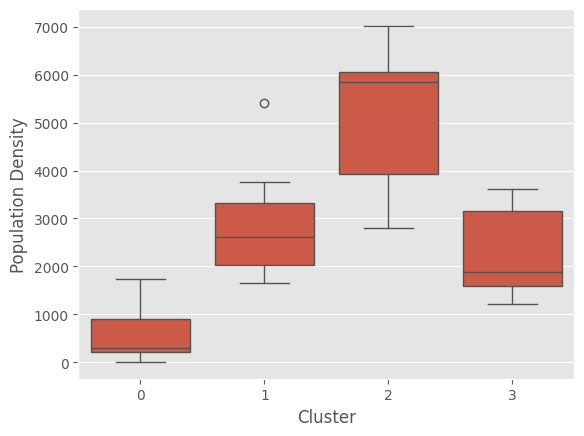

In [146]:
# do boxplot of 'Population Density' for each cluster
sns.boxplot(data=df_clustered, x='Cluster', y='Population Density')
plt.show()

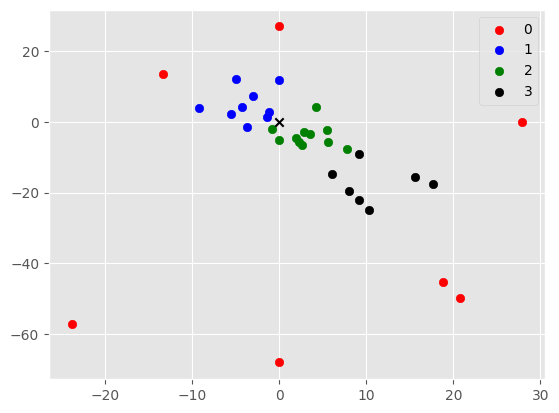

In [147]:
# plot the groups of points in different colors
colors = ['red','blue','green','black']

# group the new dataframe by 'Cluster'
grouped = df_clustered.groupby('Cluster')
# plot the groups
for name, group in grouped:
	plt.scatter(group['cart_x'],group['cart_y'],color=colors[name],label=name)
plt.scatter(0,0,color='black', marker='x')
plt.legend()
plt.show()

In [148]:
print(f'Population Density of cluster 0:\n{df_clustered[df_clustered['Cluster']==0]['Population Density']}')
print(f'Population Density of cluster 1:\n{df_clustered[df_clustered['Cluster']==1]['Population Density']}')
print(f'Population Density of cluster 2:\n{df_clustered[df_clustered['Cluster']==2]['Population Density']}')
print(f'Population Density of cluster 3:\n{df_clustered[df_clustered['Cluster']==3]['Population Density']}')




Population Density of cluster 0:
2     1034.970870
3     1730.064830
9        5.200815
21     749.081534
22     212.389261
26     289.307021
31     213.812038
Name: Population Density, dtype: float64
Population Density of cluster 1:
0     3758.623596
1     2025.468296
4     2619.120089
5     2848.743284
6     2352.122818
15    5417.942002
17    1652.315391
18    3323.070825
19    1669.114239
Name: Population Density, dtype: float64
Population Density of cluster 2:
7     2795.946571
8     3686.421646
16    4157.531892
20    6545.496301
23    4318.648935
24    5853.942037
27    5929.989035
28    6205.348910
29    5893.982048
30    3195.360659
33    7020.296346
Name: Population Density, dtype: float64
Population Density of cluster 3:
10    2799.843733
11    1220.057102
12    1814.169027
13    3622.007692
14    3525.522434
25    1888.536850
32    1383.028868
Name: Population Density, dtype: float64


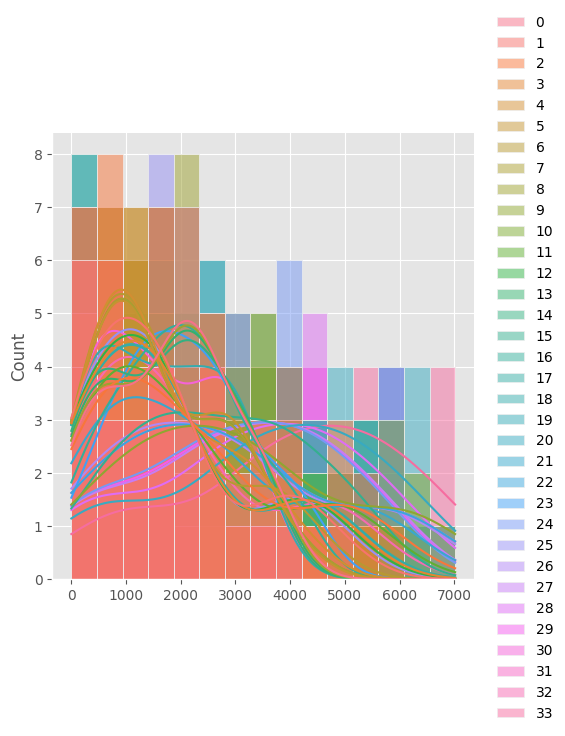

In [149]:
# compute pairwise absolute differences between population densities of the suburbs (don't take clustering into account)
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
# compute the pairwise distances
distances = pdist(df['Population Density'].values.reshape(-1,1), 'cityblock')
# convert the distances to a square matrix
dist_matrix_pop = squareform(distances)
# plot the histogram of the distances
sns.displot(dist_matrix_pop, kde=True)
plt.show()

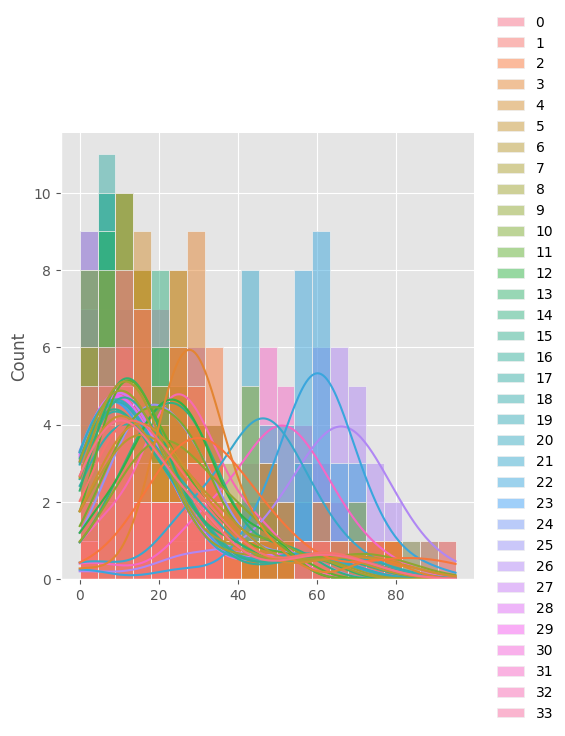

In [150]:
# compute pairwise distances between the suburbs
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
# compute the pairwise distances
distances = pdist(locs)
# convert the distances to a square matrix
dist_matrix_suburb = squareform(distances)
# plot the histogram of the distances
sns.displot(dist_matrix_suburb, kde=True)
plt.show()

In [151]:
# check the spearman rank correlation between the population density and the distance from the origin
from scipy.stats import spearmanr
spearmanr(df['Population Density'], np.linalg.norm(locs, axis=1))


SignificanceResult(statistic=np.float64(-0.7011459129106188), pvalue=np.float64(3.863658979290041e-06))

In [152]:
# create a plot of the population density and the pairwise distances between the suburbs
plt.scatter()

TypeError: scatter() missing 2 required positional arguments: 'x' and 'y'

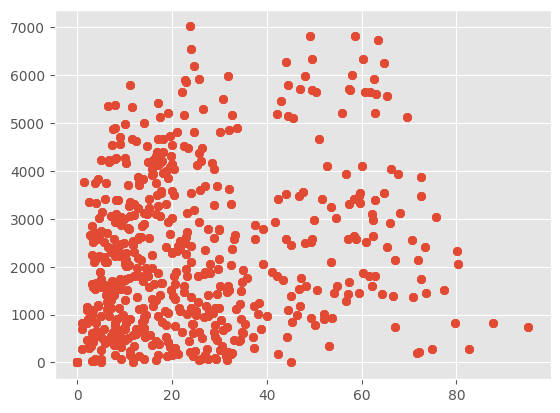

In [153]:
# create a plot of the population density difference and the pairwise distances between the suburbs

# create a plot of the population density and the pairwise distances between the suburbs
plt.scatter(dist_matrix_suburb, dist_matrix_pop)


In [154]:
# test the correlation between the population density and the pairwise distances between the suburbs
from scipy.stats import spearmanr
spearmanr(dist_matrix_suburb.flatten(), dist_matrix_pop.flatten())

SignificanceResult(statistic=np.float64(0.22563175846460468), pvalue=np.float64(8.261346636146706e-15))

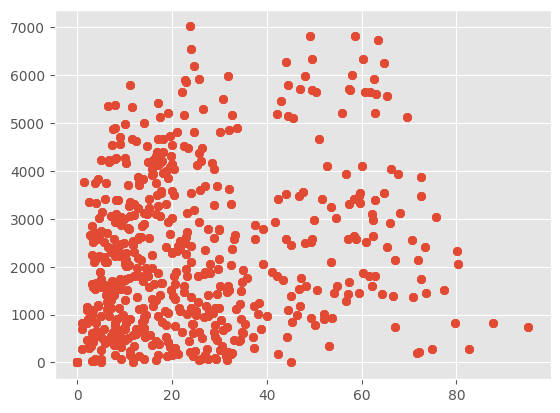

In [155]:
plt.scatter(dist_matrix_suburb.flatten(), dist_matrix_pop.flatten())

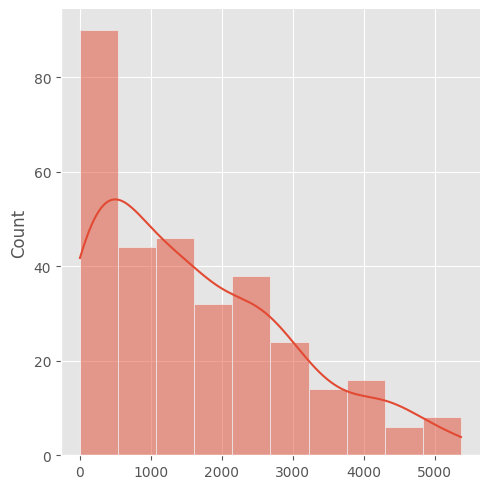

In [156]:
# density plot of the population density different for pairwise difference < 10 km
# find the indices of the points with pairwise distances < 10 km
indices = np.where(dist_matrix_suburb < 10)

# plot the density plot of the population density difference for pairwise distances < 10 km
sns.displot(np.abs(df['Population Density'].values[indices[0]] - df['Population Density'].values[indices[1]]), kde=True)
plt.show()

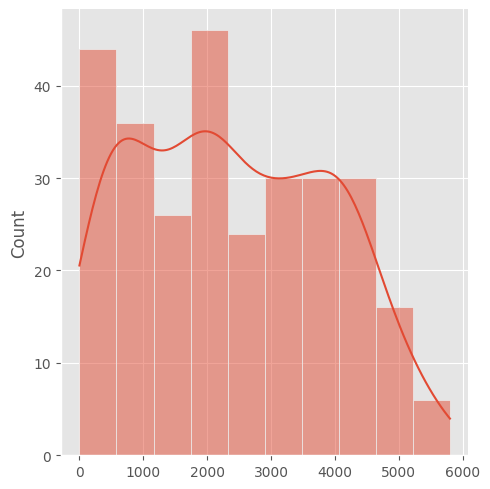

In [158]:
# density plot of the population density different for pairwise difference > 10 km < 20 km
# find the indices of the points with pairwise distances > 10 km and < 20 km
indices = np.where((dist_matrix_suburb > 10) & (dist_matrix_suburb < 20))

# plot the density plot of the population density difference for pairwise distances > 10 km and < 20 km
sns.displot(np.abs(df['Population Density'].values[indices[0]] - df['Population Density'].values[indices[1]]), kde=True)
plt.show()

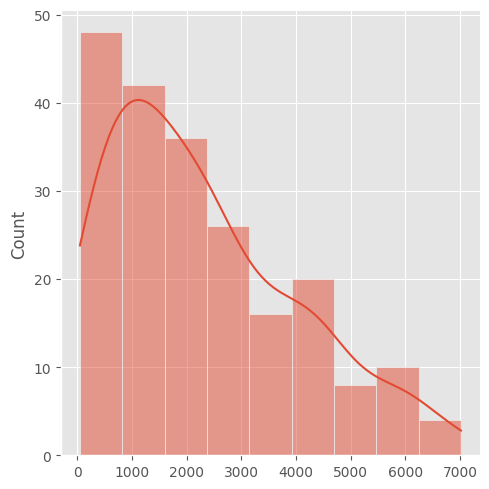

In [159]:
# density plot of the population density different for pairwise difference > 20 km < 30 km
# find the indices of the points with pairwise distances > 20 km and < 30 km
indices = np.where((dist_matrix_suburb > 20) & (dist_matrix_suburb < 30))

# plot the density plot of the population density difference for pairwise distances > 20 km and < 30 km
sns.displot(np.abs(df['Population Density'].values[indices[0]] - df['Population Density'].values[indices[1]]), kde=True)
plt.show()

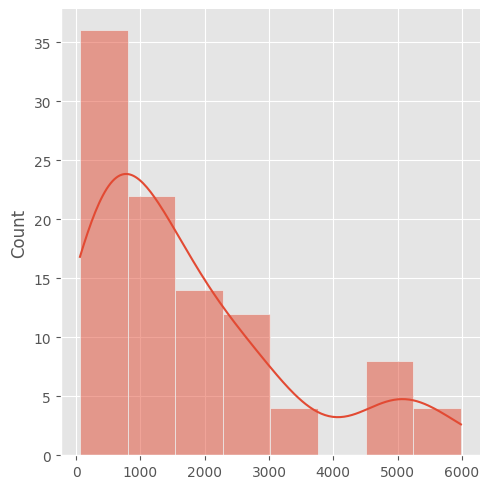

In [160]:
# density plot of the population density different for pairwise difference > 30 km < 40 km
# find the indices of the points with pairwise distances > 30 km and < 40 km
indices = np.where((dist_matrix_suburb > 30) & (dist_matrix_suburb < 40))

# plot the density plot of the population density difference for pairwise distances > 30 km and < 40 km
sns.displot(np.abs(df['Population Density'].values[indices[0]] - df['Population Density'].values[indices[1]]), kde=True)
plt.show()

c:\Users\subha\miniconda3\Lib\site-packages\libpysal\weights\util.py:826: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 2, 3, 22, 26.
  w = W(neighbors, weights, ids, **kwargs)
c:\Users\subha\miniconda3\Lib\site-packages\libpysal\weights\distance.py:844: UserWarning: The weights matrix is not fully connected: 
 There are 6 disconnected components.
 There are 4 islands with ids: 2, 3, 22, 26.
  W.__init__(


('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 26, ' is an island (no neighbors)')


c:\Users\subha\miniconda3\Lib\site-packages\esda\moran.py:1084: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
C:\Users\subha\AppData\Local\Temp\ipykernel_7936\2314099606.py:32: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  gdf = gpd.GeoDataFrame({'data': data, 'lisa': lisa.q, 'geometry': [lps.cg.Point(c) for c in coords]})


Local Moran's I values: [ 0.0581991  -0.00250354 -0.         -0.         -0.00526338 -0.02477509
  0.0909079  -0.09552822  0.32204961  0.48256643  0.04995201 -0.10130695
  0.24645814  0.22857793 -0.11082179  0.7717281   0.35051837 -0.44966215
  0.00741619 -0.51730787  1.24857132  1.57187802 -0.          0.49607498
  0.93902785  0.11039107 -0.          1.05576039  1.14870179  1.02565977
  0.08338119  1.57187802  0.27832899  1.38100865]
p-values: [0.26  0.481 0.001 0.001 0.457 0.097 0.241 0.001 0.001 0.421 0.121 0.408
 0.158 0.004 0.27  0.001 0.004 0.001 0.445 0.001 0.001 0.06  0.001 0.001
 0.001 0.316 0.001 0.001 0.001 0.001 0.001 0.124 0.334 0.001]
Clusters/Outliers classification: [3 3 2 1 1 1 1 2 2 1 3 1 1 3 1 1 1 1 1]


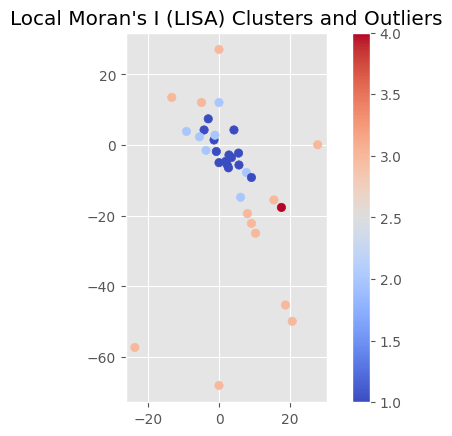

In [161]:
import numpy as np
import libpysal as lps
import esda
import geopandas as gpd
import matplotlib.pyplot as plt

population_density = df[['Population Density']].values

# Example data: values (e.g., crime rates or housing prices) for different spatial units
data = np.array(population_density[:,0].astype(float))

# Coordinates representing the locations of the spatial units
coords = np.asarray(locs)

# Create spatial weights based on distance
weights = lps.weights.DistanceBand(coords, threshold=10)
weights.transform = 'r'

# Calculate Local Moran's I
lisa = esda.Moran_Local(data, weights)

# Output the Local Moran's I statistic for each point
print("Local Moran's I values:", lisa.Is)
print("p-values:", lisa.p_sim)

# Identify clusters and outliers
# Local clusters where p-value < 0.05 (typically interpreted as significant)
significant_clusters = lisa.q[lisa.p_sim < 0.05]
print("Clusters/Outliers classification:", significant_clusters)

# Visualize the LISA result
gdf = gpd.GeoDataFrame({'data': data, 'lisa': lisa.q, 'geometry': [lps.cg.Point(c) for c in coords]})
gdf.plot(column='lisa', cmap='coolwarm', legend=True)
plt.title("Local Moran's I (LISA) Clusters and Outliers")
plt.show()


In [162]:
# overall Moran's I
mi = esda.Moran(data, weights)
print("Moran's I:", mi.I)
print("p-value:", mi.p_sim)


Moran's I: 0.4193974461571781
p-value: 0.002


In [165]:
from scipy import spatial
# create a connection matrix.
W=spatial.distance.pdist(locs)
W=spatial.distance.squareform(W)
# if (i,j) belong to different clusters, W[i,j]=0
for i in range(len(W)):
	for j in range(len(W)):
		if df_clustered['Cluster'][i] != df_clustered['Cluster'][j]:
			W[i,j] = 0

# create a spatial weights object
W_dict = {}
for i in range(len(W)):
	for j in range(len(W)):
		if W[i,j] != 0:
			if i not in W_dict:
				W_dict[i] = []
			W_dict[i].append(j)


W_lps = lps.weights.W(W_dict)
W_lps

# calculate Moran's I
mi = esda.Moran(data, W_lps)
print("Moran's I:", mi.I)
print("p-value:", mi.p_sim)



Moran's I: 0.6500140325037695
p-value: 0.001


C:\Users\subha\AppData\Local\Temp\ipykernel_7936\742784278.py:21: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W_lps = lps.weights.W(W_dict)


In [167]:
# load the feature category dictionary
import json
with open('feature_category_dict.json', 'r') as f:
	feature_category = json.load(f)

feature_category

{'2007 population': ['2007 ERP age 0-4, persons',
  '2007 ERP age 0-4, %',
  '2007 ERP age 5-9, persons',
  '2007 ERP age 5-9, %',
  '2007 ERP age 10-14, persons',
  '2007 ERP age 10-14, %',
  '2007 ERP age 15-19, persons',
  '2007 ERP age 15-19, %',
  '2007 ERP age 20-24, persons',
  '2007 ERP age 20-24, %',
  '2007 ERP age 25-44, persons',
  '2007 ERP age 25-44, %',
  '2007 ERP age 45-64, persons',
  '2007 ERP age 45-64, %',
  '2007 ERP age 65-69, persons',
  '2007 ERP age 65-69, %',
  '2007 ERP age 70-74, persons',
  '2007 ERP age 70-74, %',
  '2007 ERP age 75-79, persons',
  '2007 ERP age 75-79, %',
  '2007 ERP age 80-84, persons',
  '2007 ERP age 80-84, %',
  '2007 ERP age 85+, persons',
  '2007 ERP age 85+, %',
  '2007 ERP, total'],
 '2007-2012 population change': ['% change, 2007-2012, age 0-4',
  '% change, 2007-2012, age 5-9',
  '% change, 2007-2012, age 10-14',
  '% change, 2007-2012, age 15-19',
  '% change, 2007-2012, age 20-24',
  '% change, 2007-2012, age 25-44',
  '% cha

In [168]:
land_use_df = df[feature_category['Land Use']].copy()
land_use_df

,Commercial (km^2),Commercial (%),Industrial (km^2),Industrial (%),Residential (km^2),Residential (%),Rural (km^2),Rural (%),Other (km^2),Other (%)
0,0.110250,2.874503,0.005093,0.132784,2.894001,75.454089,0.000000,0.000000,0.826102,21.538624
1,1.013147,23.425767,0.177854,4.112305,2.198204,50.826408,0.000000,0.000000,0.935720,21.635520
2,0.782388,2.215516,1.763098,4.992626,4.486082,12.703395,1.935031,5.479494,26.347439,74.608969
3,0.228507,1.609852,0.407614,2.871681,10.370552,73.061560,0.041521,0.292517,3.146073,22.164391
4,0.123132,2.421885,0.168014,3.304669,3.661186,72.011763,0.000000,0.000000,1.131817,22.261683
5,0.412947,8.314224,0.352390,7.094986,2.122709,42.738377,0.000000,0.000000,2.078705,41.852413
6,0.140827,1.591747,0.092401,1.044400,5.724229,64.700094,0.000000,0.000000,2.889870,32.663760
7,0.435033,5.748787,0.000000,0.000000,5.350733,70.707841,0.000000,0.000000,1.781617,23.543372
8,0.129991,4.727724,0.000000,0.000000,2.309011,83.977777,0.000000,0.000000,0.310548,11.294499
9,0.021298,0.070105,0.109149,0.359280,0.006963,0.022921,7.050213,23.206867,23.192232,76.340827


In [169]:
# keep only the land use features with '%' in the name
land_use_df = land_use_df[[col for col in land_use_df.columns if not '%' in col]]
land_use_df

,Commercial (km^2),Industrial (km^2),Residential (km^2),Rural (km^2),Other (km^2)
0,0.110250,0.005093,2.894001,0.000000,0.826102
1,1.013147,0.177854,2.198204,0.000000,0.935720
2,0.782388,1.763098,4.486082,1.935031,26.347439
3,0.228507,0.407614,10.370552,0.041521,3.146073
4,0.123132,0.168014,3.661186,0.000000,1.131817
5,0.412947,0.352390,2.122709,0.000000,2.078705
6,0.140827,0.092401,5.724229,0.000000,2.889870
7,0.435033,0.000000,5.350733,0.000000,1.781617
8,0.129991,0.000000,2.309011,0.000000,0.310548
9,0.021298,0.109149,0.006963,7.050213,23.192232


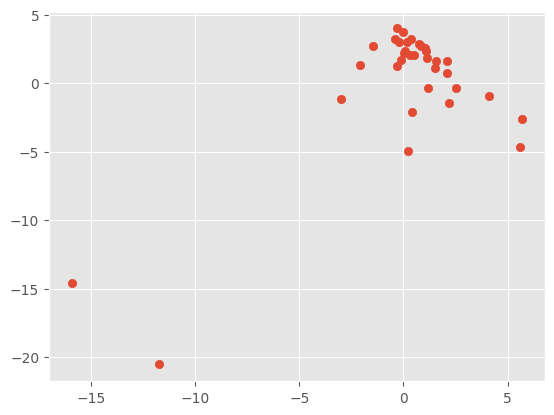

In [170]:
# do multidimensional scaling on the land use data to visualize the data in 2D
from sklearn.manifold import MDS
mds = MDS(n_components=2)
land_use_mds = mds.fit_transform(land_use_df)
plt.scatter(land_use_mds[:,0],land_use_mds[:,1])
plt.show()

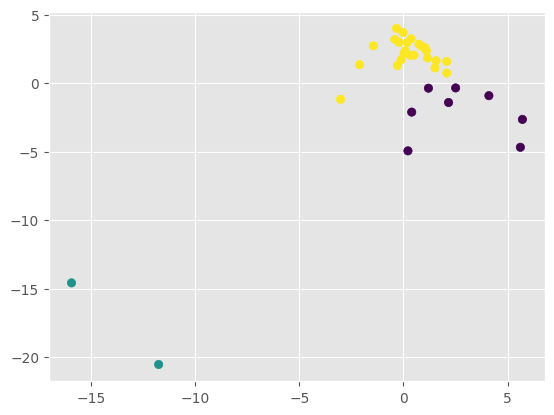

In [171]:
# do hierarchical clustering on the land use data
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=3)
agg.fit(land_use_df)

# plot the clusters
plt.scatter(land_use_mds[:,0],land_use_mds[:,1],c=agg.labels_)
plt.show()


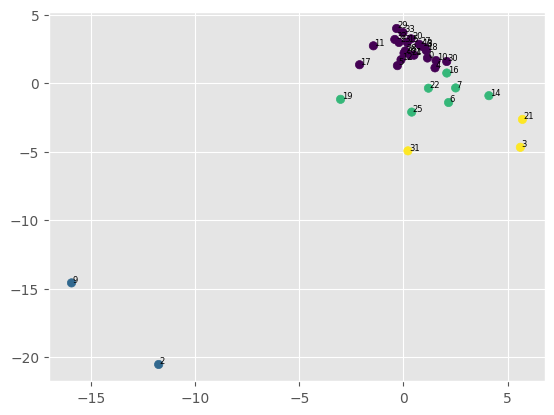

In [172]:
# do k-means clustering on the land use data
kmeans = KMeans(n_clusters=4, random_state=0, n_init=100)
kmeans.fit(land_use_df)

# plot the clusters
plt.scatter(land_use_mds[:,0],land_use_mds[:,1],c=kmeans.labels_)
# annotate each point with the corresponding point index
for i in range(len(land_use_mds)):
	plt.annotate(i, (land_use_mds[i,0]+0.05,land_use_mds[i,1]+.05), size=6)

plt.show()


In [173]:
# agreement analysis between the land use clustering and the locational clustering

kmeans_locations = KMeans(n_clusters=4, random_state=0, n_init=100)
kmeans_locations.fit(locs)

# compute NMI between the land use clustering and the locational clustering
nmi = normalized_mutual_info_score(kmeans.labels_, kmeans_locations.labels_)
print('NMI between land use clustering and locational clustering:',nmi)


NMI between land use clustering and locational clustering: 0.25005304660951344


Moran's I for land use: 0.20228402218371674
p-value: 0.003
Local Moran's I values for land use: [ 5.04736871e-02  4.84500408e-02  2.34548532e+00  5.60777774e-02
  4.49876698e-02  2.42981417e-02  1.19798781e-03  7.73301728e-02
  1.66562867e-01  2.35453652e+00  9.41942275e-02  9.33289352e-02
  6.83898375e-02  1.04158635e-01  7.06327397e-02  5.48664878e-02
  1.19876152e-01 -6.46882320e-03  5.60900953e-02 -1.13164585e-01
  1.69107683e-01 -1.78362696e-01 -7.81523734e-02  1.37051629e-01
  1.17125395e-01 -7.59017469e-02 -3.74205740e-01  1.65898483e-01
  1.20166992e-01  1.73848219e-01  1.58709989e-01  3.66846478e-01
  8.83735875e-02  1.73562952e-01]
p-values for land use: [0.488 0.491 0.007 0.004 0.492 0.482 0.468 0.001 0.002 0.009 0.31  0.31
 0.259 0.327 0.262 0.488 0.001 0.464 0.488 0.361 0.003 0.002 0.002 0.001
 0.001 0.092 0.001 0.004 0.004 0.004 0.004 0.005 0.303 0.004]
Clusters/Outliers classification for land use: [1 1 3 3 1 3 3 2 2 3 3 2 3 3 3 3 1 3]


C:\Users\subha\AppData\Local\Temp\ipykernel_7936\2240153721.py:26: FutureWarning: Objects based on the `Geometry` class will deprecated and removed in a future version of libpysal.
  gdf = gpd.GeoDataFrame({'data': land_use_pca.flatten(), 'lisa': lisa.q, 'geometry': [lps.cg.Point(c) for c in coords]})


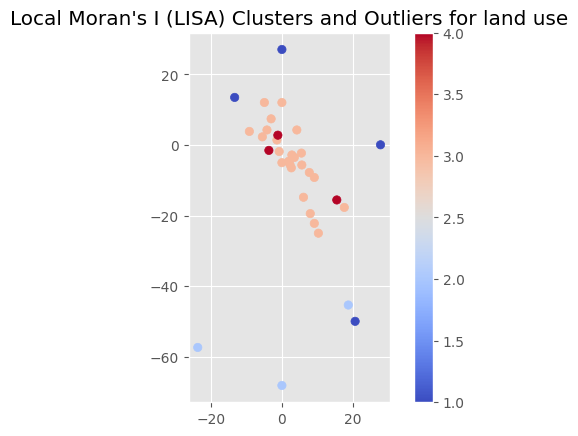

Outliers for land use: [ 2  3  9 31]
Clusters for land use: [21 22 26]
High-High clusters for land use: [ 0  1  4  5  6  7  8 10 11 12 13 14 15 16 18 20 23 24 27 28 29 30 32 33]
Low-Low clusters for land use: [17 19 25]


In [174]:
# map the land use to 1d using PCA and perform moran's I
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
land_use_pca = pca.fit_transform(land_use_df)

# use the earlier W_lps
mi = esda.Moran(land_use_pca, W_lps)
print("Moran's I for land use:", mi.I)
print("p-value:", mi.p_sim)



# compute local moran's I for land use
lisa = esda.Moran_Local(land_use_pca, W_lps)

# Output the Local Moran's I statistic for each point
print("Local Moran's I values for land use:", lisa.Is)
print("p-values for land use:", lisa.p_sim)

# Identify clusters and outliers
# Local clusters where p-value < 0.05 (typically interpreted as significant)
significant_clusters = lisa.q[lisa.p_sim < 0.05]
print("Clusters/Outliers classification for land use:", significant_clusters)

# Visualize the LISA result
gdf = gpd.GeoDataFrame({'data': land_use_pca.flatten(), 'lisa': lisa.q, 'geometry': [lps.cg.Point(c) for c in coords]})
gdf.plot(column='lisa', cmap='coolwarm', legend=True)
plt.title("Local Moran's I (LISA) Clusters and Outliers for land use")
plt.show()
# print the outliers
print('Outliers for land use:',np.where(lisa.q==1)[0])
# print the clusters
print('Clusters for land use:',np.where(lisa.q==2)[0])
# print the high-high clusters
print('High-High clusters for land use:',np.where(lisa.q==3)[0])
# print the low-low clusters
print('Low-Low clusters for land use:',np.where(lisa.q==4)[0])



In [175]:
# do t-SNE on the land use data
from sklearn.manifold import TSNE
tsne = TSNE(n_components=1)
land_use_tsne = tsne.fit_transform(land_use_df)


# use the earlier W_lps
mi = esda.Moran(land_use_tsne, W_lps)
print("Moran's I for land use:", mi.I)
print("p-value:", mi.p_sim)


Moran's I for land use: -0.14941064788507247
p-value: 0.002


Moran's I for land use: 0.35297045666200416
p-value: 0.001


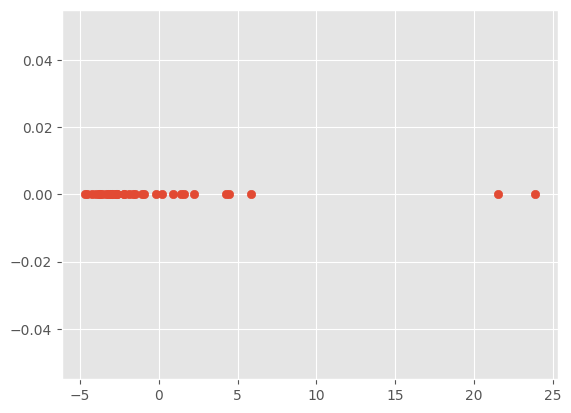

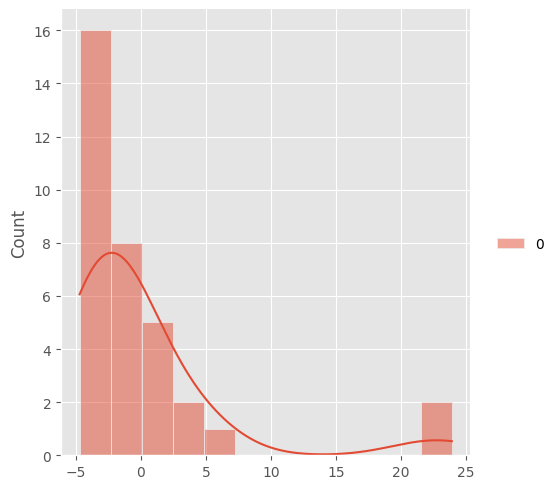

In [176]:
# do MDS to 1D on the land use data
mds = MDS(n_components=1)
land_use_mds = mds.fit_transform(land_use_df)

# use the earlier W_lps
mi = esda.Moran(land_use_mds, W_lps)
print("Moran's I for land use:", mi.I)
print("p-value:", mi.p_sim)

# plot the land use data in 1D
plt.scatter(land_use_mds, np.zeros(len(land_use_mds)))
plt.show()

sns.displot(land_use_mds, kde=True)

In [177]:
land_use_df

,Commercial (km^2),Industrial (km^2),Residential (km^2),Rural (km^2),Other (km^2)
0,0.110250,0.005093,2.894001,0.000000,0.826102
1,1.013147,0.177854,2.198204,0.000000,0.935720
2,0.782388,1.763098,4.486082,1.935031,26.347439
3,0.228507,0.407614,10.370552,0.041521,3.146073
4,0.123132,0.168014,3.661186,0.000000,1.131817
5,0.412947,0.352390,2.122709,0.000000,2.078705
6,0.140827,0.092401,5.724229,0.000000,2.889870
7,0.435033,0.000000,5.350733,0.000000,1.781617
8,0.129991,0.000000,2.309011,0.000000,0.310548
9,0.021298,0.109149,0.006963,7.050213,23.192232


In [178]:
# now use 'Services' category
services_df = df[feature_category['Services']].copy()
services_df

,Public Hospitals,Private Hospitals,Community Health Centres,Bush Nursing Centres,Allied Health,Alternative Health,Child Protection and Family,Dental,Disability,General Practice,...,Aged Care (Low Care),Aged Care (SRS),Kinder and/or Childcare,Primary Schools,Secondary Schools,P12 Schools,Other Schools,Centrelink Offices,Medicare Offices,Medicare Access Points
0,0,1,1,0,10,5,0,0,0,2,...,31,0,4,3,0,0,1,0,0,0
1,0,0,1,0,13,1,0,1,1,4,...,0,0,1,2,2,0,1,0,0,0
2,1,0,1,0,15,0,0,1,1,8,...,0,0,2,6,1,1,0,0,0,0
3,0,1,0,0,30,8,0,7,9,9,...,179,45,10,5,2,0,0,0,0,0
4,0,0,1,0,13,1,0,1,0,5,...,150,0,3,4,1,1,0,0,0,0
5,3,3,6,0,85,4,9,15,13,23,...,182,0,2,5,2,0,0,1,0,0
6,0,0,2,0,17,0,0,2,3,7,...,280,36,4,5,1,0,1,0,0,0
7,0,1,0,0,13,11,0,5,4,5,...,45,46,6,4,0,0,1,0,1,0
8,0,4,0,0,12,7,0,8,4,6,...,61,0,0,2,0,2,0,0,0,0
9,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [179]:
# scale the data
scaler_services = StandardScaler()
services_scaled = scaler_services.fit_transform(services_df)
services_scaled

services_df = services_scaled

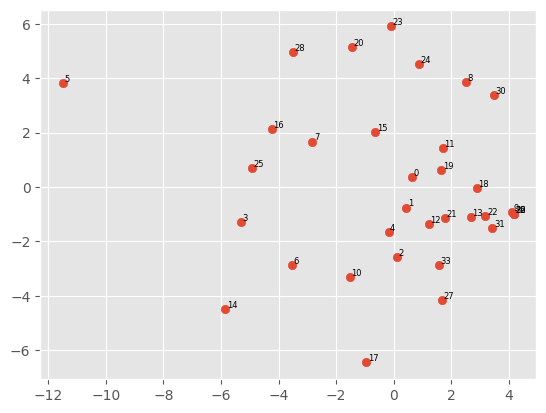

In [180]:
# MDS to 2D for services data
mds = MDS(n_components=2)
services_mds = mds.fit_transform(services_df)
plt.scatter(services_mds[:,0],services_mds[:,1])
# annotate each point with the corresponding point index
for i in range(len(services_mds)):
	plt.annotate(i, (services_mds[i,0]+0.05,services_mds[i,1]+.05), size=6)
	
plt.show()


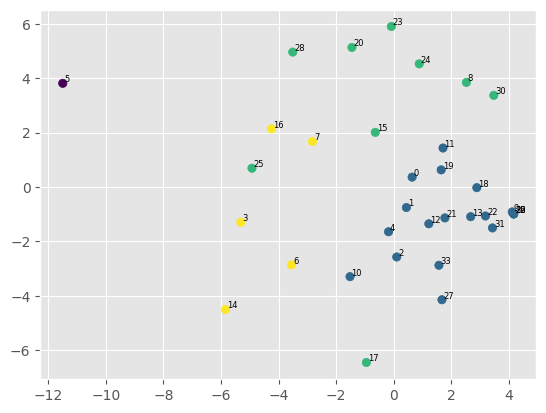

In [181]:
# do k-means clustering on the services data
kmeans = KMeans(n_clusters=4, random_state=0, n_init=100)
kmeans.fit(services_df)

# plot the clusters
plt.scatter(services_mds[:,0],services_mds[:,1],c=kmeans.labels_)

# annotate each point with the corresponding point index
for i in range(len(services_mds)):
	plt.annotate(i, (services_mds[i,0]+0.05,services_mds[i,1]+.05), size=6)

plt.show()

In [182]:
# agreement analysis between the services clustering and the locational clustering

kmeans_locations = KMeans(n_clusters=4, random_state=0, n_init=100)
kmeans_locations.fit(locs)

# compute NMI between the services clustering and the locational clustering
nmi = normalized_mutual_info_score(kmeans.labels_, kmeans_locations.labels_)
print('NMI between services clustering and locational clustering:',nmi)


NMI between services clustering and locational clustering: 0.10052815013903102


In [183]:
# map the services to 1d using PCA and perform moran's I
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
services_pca = pca.fit_transform(services_df)

# use the earlier W_lps
mi = esda.Moran(services_pca, W_lps)
print("Moran's I for services:", mi.I)
print("p-value:", mi.p_sim)


Moran's I for services: 0.0038704729571599444
p-value: 0.265


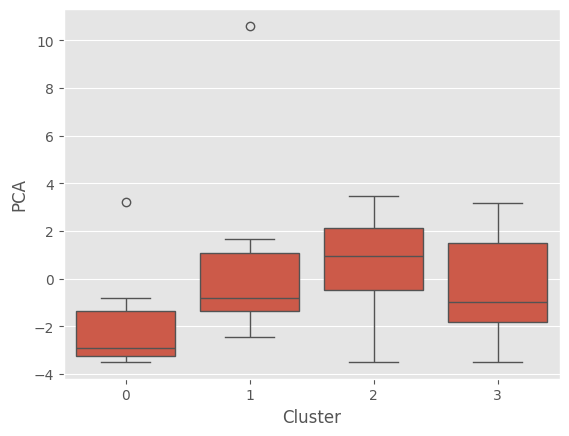

In [184]:
# do cluster-wise boxplot of the pca-transformed services data
services_pca_df = pd.DataFrame(services_pca, columns=['PCA'])
services_pca_df['Cluster'] = df_clustered['Cluster']
sns.boxplot(data=services_pca_df, x='Cluster', y='PCA')
plt.show()

In [185]:
# do anova on the pca-transformed services data
from scipy.stats import f_oneway
cluster_0 = services_pca_df[services_pca_df['Cluster']==0]['PCA']
cluster_1 = services_pca_df[services_pca_df['Cluster']==1]['PCA']
cluster_2 = services_pca_df[services_pca_df['Cluster']==2]['PCA']
cluster_3 = services_pca_df[services_pca_df['Cluster']==3]['PCA']
f_oneway(cluster_0, cluster_1, cluster_2, cluster_3)


F_onewayResult(statistic=np.float64(1.381307449056181), pvalue=np.float64(0.2674945230159627))

Moran's I for aged care (low care): 0.011307381736464875
p-value: 0.25
SignificanceResult(statistic=np.float64(0.18667761828526253), pvalue=np.float64(0.2904562621220285))
SignificanceResult(statistic=np.float64(-0.14766339498001615), pvalue=np.float64(0.4046218994145334))


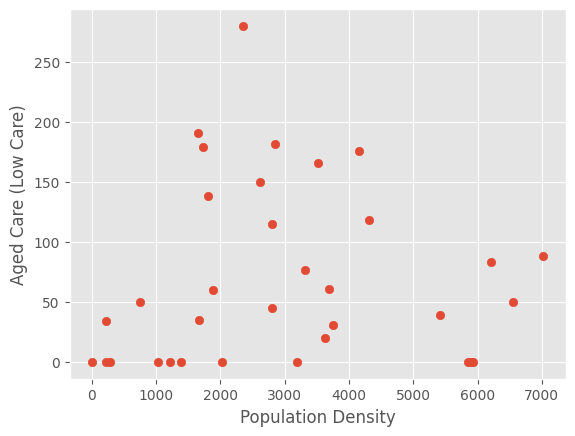

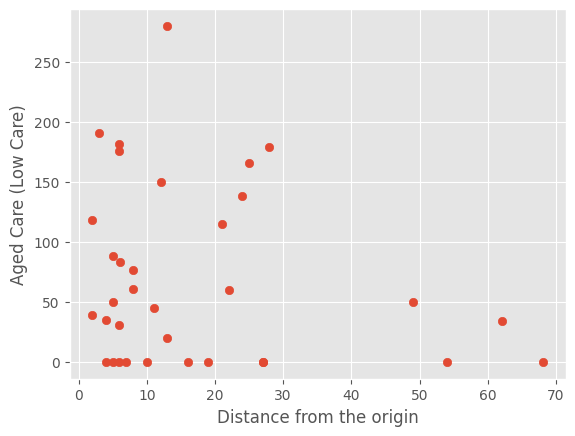

In [186]:
# check Moran's I for the 'Aged Care (Low Care)' feature
aged_care_low_care = df['Aged Care (Low Care)'].values
aged_care_low_care = aged_care_low_care.reshape(-1,1)
# use the earlier W_lps
mi = esda.Moran(aged_care_low_care, W_lps)
print("Moran's I for aged care (low care):", mi.I)
print("p-value:", mi.p_sim)

# check correlation between 'Aged Care (Low Care)' and 'Population Density'
from scipy.stats import spearmanr
print(spearmanr(df['Population Density'], df['Aged Care (Low Care)']))

# check correlation between distance from the origin and 'Aged Care (Low Care)'
print(spearmanr(np.linalg.norm(locs, axis=1), df['Aged Care (Low Care)']))

# plot for 'Aged Care (Low Care)' and 'Population Density'
plt.scatter(df['Population Density'], df['Aged Care (Low Care)'])
plt.xlabel('Population Density')
plt.ylabel('Aged Care (Low Care)')
plt.show()

# plot for 'Aged Care (Low Care)' and distance from the origin
plt.scatter(np.linalg.norm(locs, axis=1), df['Aged Care (Low Care)'])
plt.xlabel('Distance from the origin')
plt.ylabel('Aged Care (Low Care)')
plt.show()


Moran's I for public hospital separations: -0.11817549484181573
p-value: 0.066
SignificanceResult(statistic=np.float64(0.30297937356760885), pvalue=np.float64(0.08154670795083545))
SignificanceResult(statistic=np.float64(-0.10252100840336134), pvalue=np.float64(0.563967364565616))


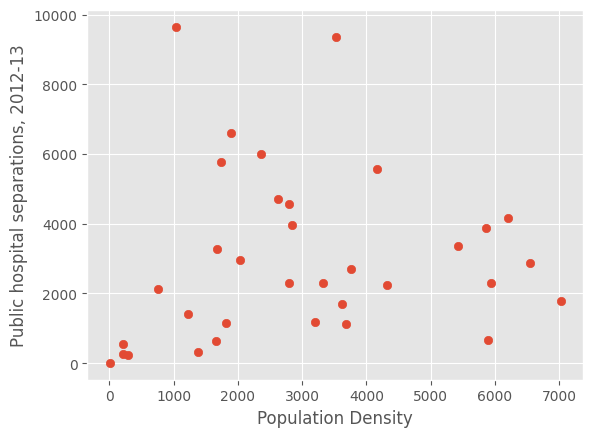

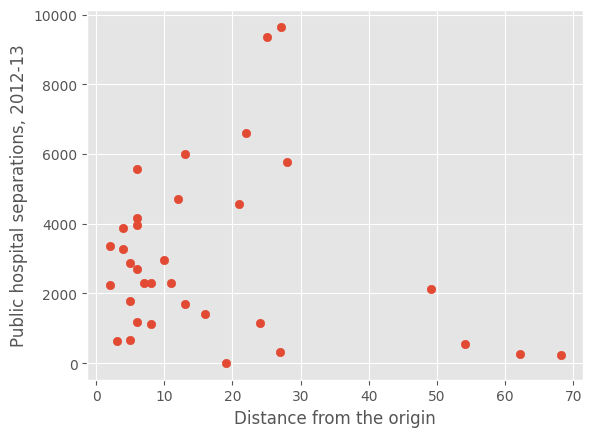

In [187]:
# check Moran's I for the 'Public hospital separations, 2012-13' feature
public_hospital_separations = df['Public hospital separations, 2012-13'].values
public_hospital_separations = public_hospital_separations.reshape(-1,1)
# use the earlier W_lps
mi = esda.Moran(public_hospital_separations, W_lps)
print("Moran's I for public hospital separations:", mi.I)
print("p-value:", mi.p_sim)

# check correlation between 'Public hospital separations, 2012-13' and 'Population Density'
from scipy.stats import spearmanr
print(spearmanr(df['Population Density'], df['Public hospital separations, 2012-13']))

# check correlation between distance from the origin and 'Public hospital separations, 2012-13'
print(spearmanr(np.linalg.norm(locs, axis=1), df['Public hospital separations, 2012-13']))

# plot for 'Public hospital separations, 2012-13' and 'Population Density'
plt.scatter(df['Population Density'], df['Public hospital separations, 2012-13'])
plt.xlabel('Population Density')
plt.ylabel('Public hospital separations, 2012-13')
plt.show()

# plot for 'Public hospital separations, 2012-13' and distance from the origin
plt.scatter(np.linalg.norm(locs, axis=1), df['Public hospital separations, 2012-13'])
plt.xlabel('Distance from the origin')
plt.ylabel('Public hospital separations, 2012-13')
plt.show()

In [188]:
# socio-demographic features
socio_demographic_features = [
	"Number of Households",
	"Average persons per household",
	"Occupied private dwellings",
	"Public Housing Dwellings",
	"Dwellings with no motor vehicle",
	"Dwellings with no internet",
	"Equivalent household income <$600/week",
	"Personal income <$400/week, persons",
	"Number of families",
	"Female-headed lone parent families",
	"Male-headed lone parent families",
	"IRSD (min)",
	"IRSD (max)",
	"IRSD (avg)",
	"Primary school students",
	"Secondary school students",
	"TAFE students",
	"University students",
	"Holds degree or higher, persons",
	"Did not complete year 12, persons",
	"Unemployed, persons",
	"Volunteers, persons",
	"Requires assistance with core activities, persons",
	"Aged 75+ and lives alone, persons",
	"Unpaid carer to person with disability, persons",
	"Unpaid carer of children, persons"
]






In [189]:
df_sociodemo = df[socio_demographic_features].copy()
# drop rows with NaN values
df_sociodemo = df_sociodemo.dropna()
# drop columns with non-numeric values
df_sociodemo = df_sociodemo.select_dtypes(include=[np.number])
# scale the data
scaler_sociodemo = StandardScaler()
sociodemo_scaled = scaler_sociodemo.fit_transform(df_sociodemo)
df_sociodemo

,Number of Households,Average persons per household,Occupied private dwellings,Dwellings with no internet,Equivalent household income <$600/week,"Personal income <$400/week, persons",Number of families,IRSD (min),IRSD (max),IRSD (avg),Primary school students,Secondary school students,"Holds degree or higher, persons","Did not complete year 12, persons","Volunteers, persons","Unpaid carer to person with disability, persons","Unpaid carer of children, persons"
0,5546,2.433105,5634,1062,1604,3586,3447,399.590971,1104.547350,989.990716,853,624,3686,3231,1917,1121,2735
1,2994,2.734469,2908,820,1431,3315,1940,618.859618,968.902268,801.147035,582,503,993,2490,591,574,1436
2,11051,2.964257,10328,1374,3257,8792,8909,909.043625,1058.579956,990.017281,3207,2452,3189,11159,2350,2474,8187
3,10020,2.350699,9694,1941,3287,6728,6379,884.340419,1142.758266,1017.819554,1556,1265,3275,9152,3437,2220,5361
4,4552,2.769112,4403,1497,2230,5051,3275,843.188699,1003.111777,901.678423,961,746,1326,4771,821,1249,2243
5,5288,2.495461,5606,1048,1981,4453,2798,755.707483,1059.140058,938.998830,474,430,3426,2935,1516,930,2017
6,7566,2.598731,7414,2103,3182,6933,4937,708.838704,1037.438556,930.862202,1192,1045,2461,7050,1582,1849,3521
7,7666,2.620271,7569,997,1800,5563,4995,998.481428,1167.399105,1090.625034,1711,1310,6573,3725,3566,1881,4543
8,3739,2.542926,3733,423,611,2078,2414,1058.938656,1147.312005,1103.480211,786,584,3559,1473,1795,949,2185
9,19,7.368421,32,6,7,24,16,1069.889461,1069.889461,1069.889461,7,10,19,34,17,13,32


In [190]:
# check Moran's I for the socio-demographic features
# use the earlier W_lps
tracker_p_values_sociodemo = []
for i in range(sociodemo_scaled.shape[1]):
	mi = esda.Moran(sociodemo_scaled[:,i], W_lps)
	print(f"Moran's I for socio-demographic feature {i}:", mi.I)
	print("p-value:", mi.p_sim)
	tracker_p_values_sociodemo.append(mi.p_sim)
	

Moran's I for socio-demographic feature 0: -0.08064322268343128
p-value: 0.281
Moran's I for socio-demographic feature 1: 0.053327857350418416
p-value: 0.036
Moran's I for socio-demographic feature 2: -0.042896791467331045
p-value: 0.452
Moran's I for socio-demographic feature 3: -0.07997573064407955
p-value: 0.307
Moran's I for socio-demographic feature 4: -0.10242559831294769
p-value: 0.157
Moran's I for socio-demographic feature 5: -0.09895182010997554
p-value: 0.159
Moran's I for socio-demographic feature 6: -0.1483142754919843
p-value: 0.001
Moran's I for socio-demographic feature 7: 0.14652328792248887
p-value: 0.046
Moran's I for socio-demographic feature 8: 0.18645810428955062
p-value: 0.018
Moran's I for socio-demographic feature 9: 0.19942571112029864
p-value: 0.013
Moran's I for socio-demographic feature 10: -0.1298646687487564
p-value: 0.024
Moran's I for socio-demographic feature 11: -0.12395033868048333
p-value: 0.039
Moran's I for socio-demographic feature 12: 0.38609461

In [191]:
# check which features have significant p-values
significant_features_sociodemo = np.where(np.array(tracker_p_values_sociodemo) < 0.05)[0]
for i in significant_features_sociodemo:
	print(f'Significant feature {i}: {socio_demographic_features[i]}')

Significant feature 1: Average persons per household
Significant feature 6: Equivalent household income <$600/week
Significant feature 7: Personal income <$400/week, persons
Significant feature 8: Number of families
Significant feature 9: Female-headed lone parent families
Significant feature 10: Male-headed lone parent families
Significant feature 11: IRSD (min)
Significant feature 12: IRSD (max)
Significant feature 15: Secondary school students
Significant feature 16: TAFE students


In [192]:
diversity_features =[
	"Travel time to nearest public hospital with emergency department",
	"Distance to nearest public hospital with emergency department",
	"Presentations to emergency departments due to injury",
	"Presentations to emergency departments due to injury, %",
	"Category 4 & 5 emergency department presentations",
	"Category 4 & 5 emergency department presentations, %"
]



df_diversity = df[diversity_features].copy()
# drop rows with NaN values
df_diversity = df_diversity.dropna()
# drop columns with non-numeric values
df_diversity = df_diversity.select_dtypes(include=[np.number])
# scale the data
scaler_diversity = StandardScaler()
diversity_scaled = scaler_diversity.fit_transform(df_diversity)
df_diversity


,Travel time to nearest public hospital with emergency department,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %"
0,6.630953,4.993841,679.257076,20.502456,1864.918123,56.290032
1,12.824977,10.161988,543.631989,20.647263,1683.966712,63.957428
2,11.570855,15.213189,2044.424399,20.618005,5102.134434,51.454988
3,5.093285,3.601752,1754.954941,28.537825,3062.182462,49.795026
4,11.510757,12.004044,680.401318,17.909865,1942.874353,51.141315
5,7.261573,5.514839,878.066191,20.647263,2719.917638,63.957428
6,13.252894,12.722850,1063.320056,17.909865,3036.292274,51.141315
7,8.746589,8.006951,324.067452,19.596542,847.427721,51.244433
8,7.386301,5.312177,155.249109,19.596542,405.972268,51.244433
9,19.921651,22.608084,8.837967,20.618005,22.056327,51.454988


In [193]:
# select the rows present in the locational data and the diversity data
df_diversity_with_location = df.loc[df_diversity.index]
df_diversity_with_location

,Community Name,Region,Map reference,Grid reference,Location,Population Density,Travel time to GPO (minutes),Distance to GPO (km),LGA,Primary Care Partnership,...,Distance to nearest public hospital with emergency department,Presentations to emergency departments due to injury,"Presentations to emergency departments due to injury, %",Category 4 & 5 emergency department presentations,"Category 4 & 5 emergency department presentations, %",geo_lat,geo_lon,cart_x,cart_y,Cluster Label
0,Ascot Vale,Northern and Western Metropolitan,4,B3,6km NW of Melbourne,3758.623596,9.360142,6.958742,Moonee Valley (C),Inner North West Primary Care Partnership,...,4.993841,679.257076,20.502456,1864.918123,56.290032,-37.775606,144.914871,-4.230377,4.251470,0
1,Braybrook,Northern and Western Metropolitan,4,A3,10km WNW of Melbourne,2025.468296,15.131666,11.595888,Maribyrnong (C),"HealthWest (b): Hobson's Bay, Maribyrnong, Wyn...",...,10.161988,543.631989,20.647263,1683.966712,63.957428,-37.779315,144.858155,-9.212552,3.839001,0
2,Craigieburn,Northern and Western Metropolitan,2,A3,27km N of Melbourne,1034.970870,31.994666,43.100287,Hume (C),Hume-Whittlesea Primary Care Partnership,...,15.213189,2044.424399,20.618005,5102.134434,51.454988,-37.570576,144.963028,0.000000,27.049690,-1
3,Croydon,Eastern Metropolitan,2,B4,28km E of Melbourne,1730.064830,28.992647,34.071323,Maroondah (C),Outer East Primary Care Partnership,...,3.601752,1754.954941,28.537825,3062.182462,49.795026,-37.813411,145.281013,27.933349,0.047723,-1
4,Fawkner,Northern and Western Metropolitan,4,C1,12km N of Melbourne,2619.120089,17.405267,13.047142,Moreland (C),Inner North West Primary Care Partnership,...,12.004044,680.401318,17.909865,1942.874353,51.141315,-37.705724,144.963028,0.000000,12.021947,0
5,Footscray,Northern and Western Metropolitan,4,B3,6km WNW of Melbourne,2848.743284,9.394512,7.034739,Maribyrnong (C),"HealthWest (b): Hobson's Bay, Maribyrnong, Wyn...",...,5.514839,878.066191,20.647263,2719.917638,63.957428,-37.793136,144.900092,-5.528560,2.302152,0
6,Glenroy,Northern and Western Metropolitan,4,B1,13km NNW of Melbourne,2352.122818,15.982083,14.687751,Moreland (C),Inner North West Primary Care Partnership,...,12.722850,1063.320056,17.909865,3036.292274,51.141315,-37.705617,144.906612,-4.955834,12.033903,0
7,Malvern East,Southern Metropolitan,1,D2,11km SE of Melbourne,2795.946571,13.811856,13.962712,Stonnington (C),Inner South East Partnership in Community & He...,...,8.006951,324.067452,19.596542,847.427721,51.244433,-37.883885,145.051446,7.767033,-7.788594,1
8,Malvern,Southern Metropolitan,1,C2,8km SE of Melbourne,3686.421646,11.983264,11.583241,Stonnington (C),Inner South East Partnership in Community & He...,...,5.312177,155.249109,19.596542,405.972268,51.244433,-37.864788,145.027315,5.647293,-5.665173,1
9,Melbourne Airport,Northern and Western Metropolitan,1,E4,19km NW of Melbourne,5.200815,22.650840,24.572985,Hume (C),Hume-Whittlesea Primary Care Partnership,...,22.608084,8.837967,20.618005,22.056327,51.454988,-37.692696,144.810700,-13.381261,13.470574,-1


In [194]:
# create a connection matrix. A new connection matrix is required since the diversity data has some rows removed
diversity_loc_tuple=np.array([np.asarray([i,j]) for (i,j) in zip(df_diversity_with_location['cart_x'],df_diversity_with_location['cart_y'])])
W_diversity=spatial.distance.pdist(diversity_loc_tuple)
W_diversity=spatial.distance.squareform(W_diversity)
# if (i,j) belong to different clusters, W[i,j]=0
for i in range(len(W_diversity)):
	for j in range(len(W_diversity)):
		if df_clustered['Cluster'][i] != df_clustered['Cluster'][j]:
			W_diversity[i,j] = 0

# create a spatial weights object
W_dict_diversity = {}
for i in range(len(W_diversity)):
	for j in range(len(W_diversity)):
		if W_diversity[i,j] != 0:
			if i not in W_dict_diversity:
				W_dict_diversity[i] = []
			W_dict_diversity[i].append(j)

W_lps_diversity = lps.weights.W(W_dict_diversity)
W_lps_diversity


C:\Users\subha\AppData\Local\Temp\ipykernel_7936\2501672380.py:20: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
  W_lps_diversity = lps.weights.W(W_dict_diversity)


In [195]:
# check Moran's I for the diversity features
# use the earlier W_lps_diversity
tracker_p_values_diversity = []
for i in range(diversity_scaled.shape[1]):
	mi = esda.Moran(diversity_scaled[:,i], W_lps_diversity, permutations=9999)
	print(f"Moran's I for diversity feature {i}:", mi.I)
	print("p-value:", mi.p_sim)
	tracker_p_values_diversity.append(mi.p_sim)

# check which features have significant p-values
significant_features_diversity = np.where(np.array(tracker_p_values_diversity) < 0.05)[0]
for i in significant_features_diversity:
	print(f'Significant feature {i}: {diversity_features[i]}')


Moran's I for diversity feature 0: 0.3370094943211409
p-value: 0.0009
Moran's I for diversity feature 1: 0.42116503785957843
p-value: 0.0005
Moran's I for diversity feature 2: -0.10159636363469333
p-value: 0.1607
Moran's I for diversity feature 3: 0.6225392126047804
p-value: 0.0001
Moran's I for diversity feature 4: -0.1164135841591778
p-value: 0.0729
Moran's I for diversity feature 5: 0.4979001223028213
p-value: 0.0001
Significant feature 0: Travel time to nearest public hospital with emergency department
Significant feature 1: Distance to nearest public hospital with emergency department
Significant feature 3: Presentations to emergency departments due to injury, %
Significant feature 5: Category 4 & 5 emergency department presentations, %


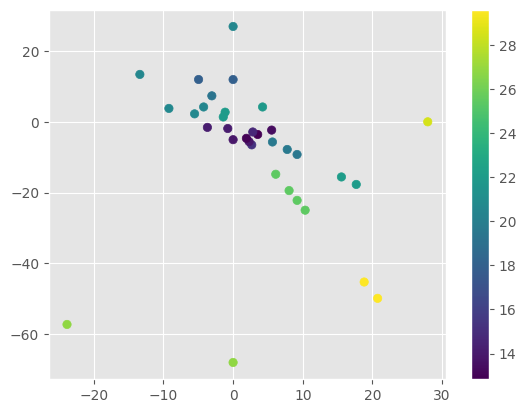

In [196]:
# plot the 'Presentations to emergency departments due to injury' feature over the map
plt.scatter(df_diversity_with_location['cart_x'],df_diversity_with_location['cart_y'],c=df_diversity_with_location['Presentations to emergency departments due to injury, %'])
plt.colorbar()
plt.show()

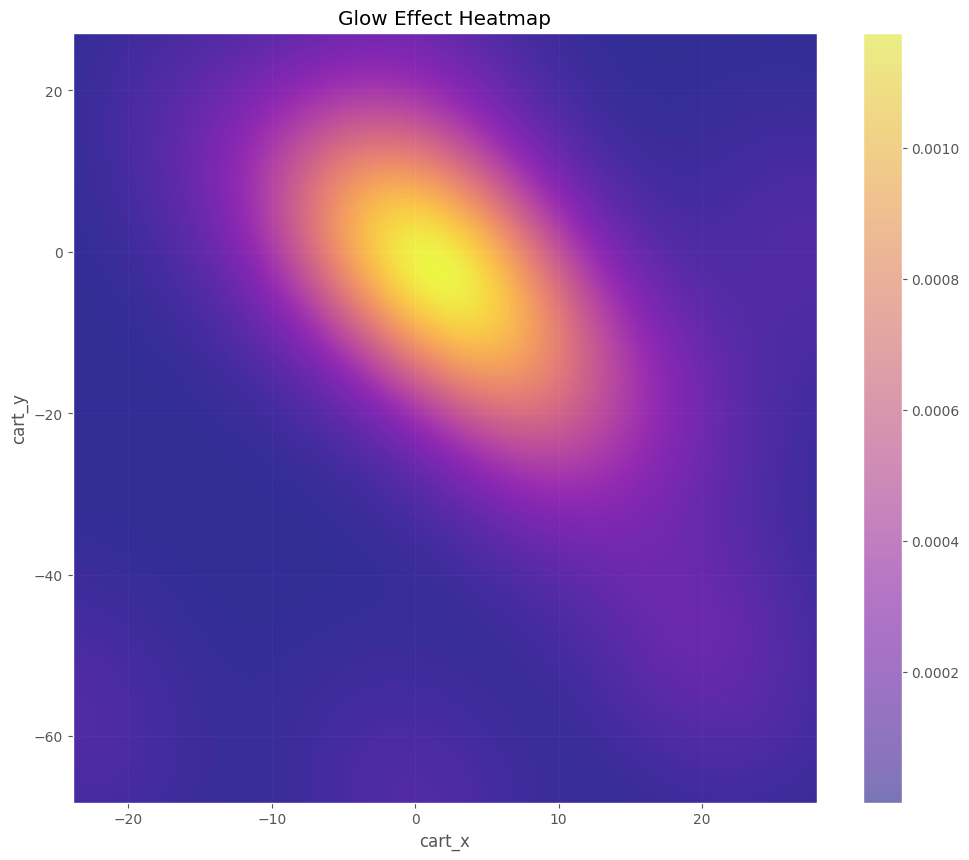

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Assuming df_diversity_with_location is already defined and contains 'cart_x' and 'cart_y'
x = df_diversity_with_location['cart_x']
y = df_diversity_with_location['cart_y']

# Perform Kernel Density Estimation
k = gaussian_kde(np.vstack([x, y]))

# Define a very dense grid for higher resolution
grid_size = 500  # Adjust for resolution
xi, yi = np.mgrid[x.min():x.max():grid_size*1j, y.min():y.max():grid_size*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# Create a glow-like heatmap
plt.figure(figsize=(12, 10))

# Plot several layers with different alpha values for a glow effect
for alpha in np.linspace(0.05, 0.5, 5):  # Adjust alpha values and the number of layers
	plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap='plasma', alpha=alpha)

# Add a colorbar and labels
plt.colorbar()
plt.xlabel('cart_x')
plt.ylabel('cart_y')
plt.title('Glow Effect Heatmap')
plt.show()


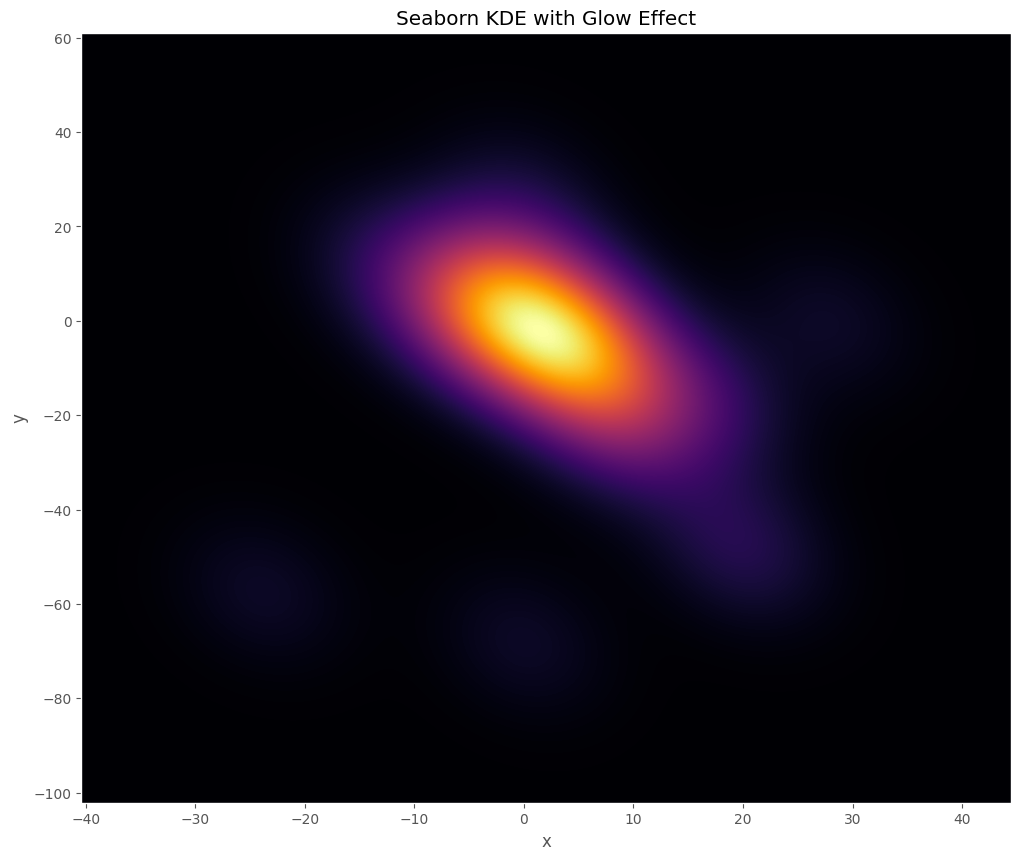

In [198]:
import seaborn as sns

# Create a DataFrame for the KDE plot
import pandas as pd
df_kde = pd.DataFrame({'x': x, 'y': y})

# Use seaborn's kdeplot for a smoother look
plt.figure(figsize=(12, 10))
sns.kdeplot(
	data=df_kde, x='x', y='y', 
	cmap='inferno',  # Choose a glowing colormap
	fill=True, 
	thresh=0,  # Show even low-density areas
	levels=1000  # Increase levels for more detail
)
plt.title('Seaborn KDE with Glow Effect')
plt.show()


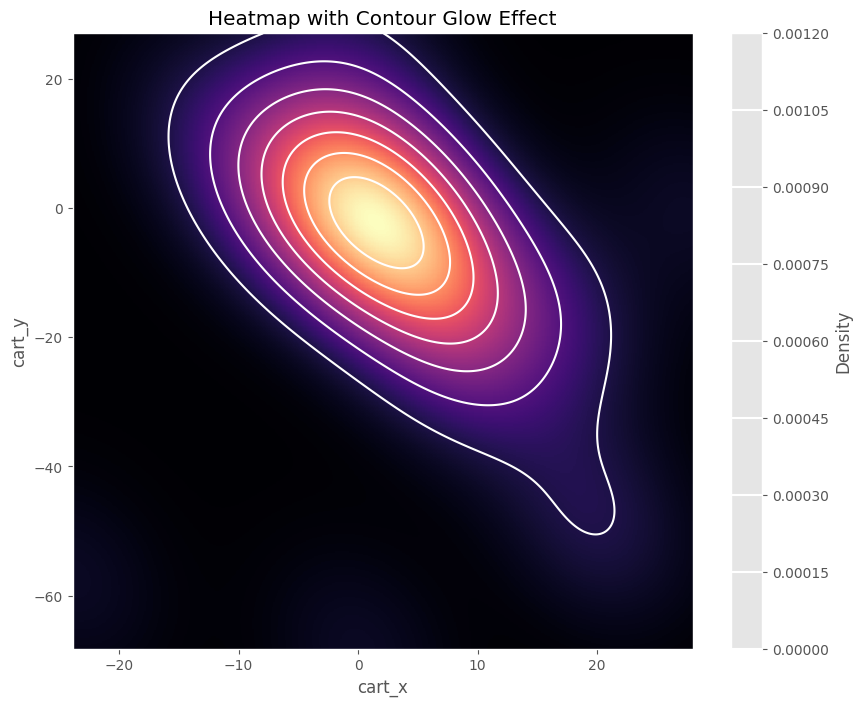

In [199]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Sample data for x and y (replace with your actual data)
x = df_diversity_with_location['cart_x']
y = df_diversity_with_location['cart_y']

# Perform Kernel Density Estimation
k = gaussian_kde(np.vstack([x, y]))

# Define a very dense grid for higher resolution
xi, yi = np.mgrid[x.min():x.max():500j, y.min():y.max():500j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# Create the heatmap background with contours for a glowing effect
plt.figure(figsize=(10, 8))
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), shading='auto', cmap='magma')
plt.contour(xi, yi, zi.reshape(xi.shape), levels=10, linewidths=1.5, colors='white')  # Add contour lines
plt.colorbar(label='Density')
plt.xlabel('cart_x')
plt.ylabel('cart_y')
plt.title('Heatmap with Contour Glow Effect')
plt.show()


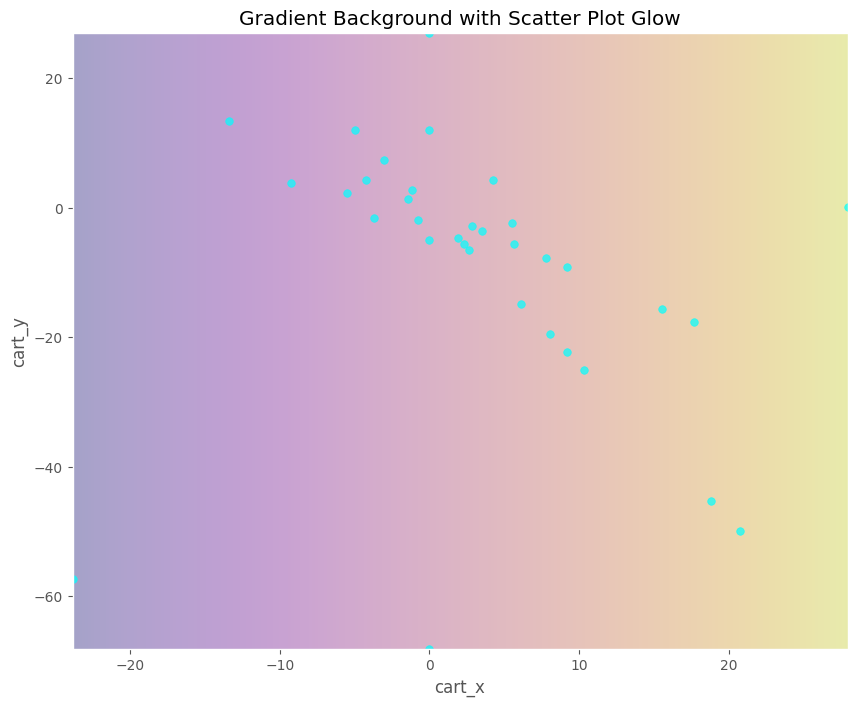

In [200]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data for x and y (replace with your actual data)
x = df_diversity_with_location['cart_x']
y = df_diversity_with_location['cart_y']

# Create the figure
plt.figure(figsize=(10, 8))

# Create a gradient background
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
plt.imshow(gradient, aspect='auto', extent=[x.min(), x.max(), y.min(), y.max()],
		   cmap='plasma', alpha=0.3)

# Scatter the points on top of the gradient
plt.scatter(x, y, s=30, alpha=0.7, color='cyan')

# Add labels and title
plt.xlabel('cart_x')
plt.ylabel('cart_y')
plt.title('Gradient Background with Scatter Plot Glow')
plt.grid(False)
plt.show()
